<a href="https://colab.research.google.com/github/Pooret/portfolio/blob/main/decoder_smiles_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

In [ ]:
# imports

import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [ ]:
# mount your drive to access your data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xzf  /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [ ]:
# load data into pandas dataframe
df = pd.read_csv("/content/data.csv")

# examine first 5 rows of data
df.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [ ]:
df.columns

Index(['molregno', 'canonical_smiles', 'activity_id', 'standard_type',
       'standard_value', 'standard_units', 'assay_id', 'tid',
       'target_chembl_id', 'organism', 'pref_name', 'mw_freebase', 'alogp',
       'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ro5_violations',
       'cx_most_apka', 'cx_most_bpka', 'cx_logp', 'cx_logd',
       'molecular_species', 'full_molformula', 'full_mwt', 'aromatic_rings',
       'heavy_atoms', 'qed_weighted', 'mw_monoisotopic', 'hba_lipinski',
       'hbd_lipinski', 'num_lipinski_ro5_violations', 'np_likeness_score',
       'bei', 'le', 'lle', 'sei'],
      dtype='object')

Feature Descriptions    
    
    1. molregno
    Description: Molecule Registration Number in the ChEMBL database.
    Purpose: A unique identifier for each molecule. It's used to reference and retrieve specific molecules within the database.
    2. canonical_smiles
    Description: Canonical SMILES (Simplified Molecular Input Line Entry System) representation of the molecule.
    Purpose: Provides a standardized string notation to describe the molecule's structure, useful for computational analyses and database searches.
    3. activity_id
    Description: Unique identifier for an activity record in the ChEMBL database.
    Purpose: Links a molecule to a specific bioactivity measurement against a target in a particular assay.
    4. standard_type
    Description: The type of bioactivity measurement, e.g., 'IC50', 'Ki', 'EC50', 'Potency'.
    Purpose: Indicates the kind of biological activity measured, helping to interpret the activity value.
    5. standard_value
    Description: The numerical value of the bioactivity measurement, standardized across the database.
    Purpose: Quantifies the molecule's bioactivity, allowing comparisons between different compounds and assays.
    6. standard_units
    Description: The units for the standard_value, e.g., 'nM' (nanomolar).
    Purpose: Ensures consistency in measurement units for accurate interpretation of bioactivity data.
    7. assay_id
    Description: Unique identifier for the assay in which the bioactivity was measured.
    Purpose: Allows retrieval of details about the experimental conditions and protocols used.
    8. tid
    Description: Target ID in the ChEMBL database.
    Purpose: Unique identifier for the biological target (e.g., protein, enzyme) that the molecule was tested against.
    9. target_chembl_id
    Description: The ChEMBL identifier for the target, formatted as 'CHEMBLXXXX'.
    Purpose: Provides a standardized ID to reference the target, facilitating cross-referencing within the database.
    10. organism
    Description: The organism from which the target was derived, e.g., 'Homo sapiens' (human).
    Purpose: Indicates the biological source of the target, important for understanding species-specific activity.
    11. pref_name
    Description: Preferred name of the target, e.g., 'Beta-2 adrenergic receptor'.
    Purpose: Provides a human-readable name for the target, aiding in data interpretation.
    12. mw_freebase
    Description: Molecular Weight of the molecule in its free base form.
    Purpose: The mass of the neutral molecule without counterions or salts, important for pharmacokinetic predictions.
    13. alogp
    Description: Calculated octanol-water partition coefficient (LogP) using the ALOGP algorithm.
    Purpose: Measures lipophilicity, affecting absorption, distribution, and membrane permeability.
    14. hba
    Description: Number of Hydrogen Bond Acceptors in the molecule.
    Purpose: Influences solubility and binding interactions; hydrogen bond acceptors are typically oxygen or nitrogen atoms.
    15. hbd
    Description: Number of Hydrogen Bond Donors in the molecule.
    Purpose: Affects molecular interactions; hydrogen bond donors are usually -OH or -NH groups.
    16. psa
    Description: Polar Surface Area of the molecule.
    Purpose: Represents the surface area occupied by polar atoms, influencing membrane permeability and bioavailability.
    17. rtb
    Description: Number of Rotatable Bonds in the molecule.
    Purpose: Indicates molecular flexibility; fewer rotatable bonds can enhance oral bioavailability.
    18. ro3_pass
    Description: Rule of Three (Ro3) Pass flag (True/False).
    Purpose: Indicates whether the molecule meets the Rule of Three criteria, used in fragment-based drug discovery.
    19. num_ro5_violations
    Description: Number of violations of Lipinski's Rule of Five.
    Purpose: Quantifies how many of Lipinski's rules the molecule violates, indicating potential issues with oral bioavailability.
    20. cx_most_apka
    Description: Most acidic predicted pKa value calculated using ChemAxon software.
    Purpose: Estimates the pH at which the molecule donates a proton, important for ionization and solubility at physiological pH.
    21. cx_most_bpka
    Description: Most basic predicted pKa value calculated using ChemAxon software.
    Purpose: Estimates the pH at which the molecule accepts a proton, influencing ionization state and interactions.
    22. cx_logp
    Description: Calculated LogP value using ChemAxon methods.
    Purpose: Another measure of lipophilicity, providing an alternative calculation for comparison.
    23. cx_logd
    Description: Calculated LogD at pH 7.4 using ChemAxon methods.
    Purpose: Represents the distribution coefficient, accounting for ionization at physiological pH, relevant for pharmacokinetics.
    24. molecular_species
    Description: Ionization state of the molecule at physiological pH.
    Possible Values: 'Neutral', 'Acid', 'Base', 'Zwitterion'.
    Purpose: Indicates the predominant form in the body, affecting absorption and distribution.
    25. full_molformula
    Description: Full Molecular Formula of the molecule.
    Purpose: Provides elemental composition, useful for reference and validation of structure.
    26. full_mwt
    Description: Full Molecular Weight of the molecule, including all atoms and counterions.
    Purpose: Reflects the complete mass as it might exist in a formulation, important for dosing.
    27. aromatic_rings
    Description: Number of Aromatic Rings in the molecule.
    Purpose: Aromatic rings contribute to binding interactions and stability; common in many drugs.
    28. heavy_atoms
    Description: Number of Heavy Atoms (non-hydrogen atoms) in the molecule.
    Purpose: Used in calculations like ligand efficiency metrics.
    29. qed_weighted
    Description: Quantitative Estimate of Drug-likeness (QED) score.
    Purpose: A composite score (0 to 1) quantifying drug-like properties; higher values indicate greater drug-likeness.
    30. mw_monoisotopic
    Description: Monoisotopic Molecular Weight of the molecule.
    Purpose: Calculated using the most abundant isotope of each element; important in mass spectrometry.
    31. hba_lipinski
    Description: Number of Hydrogen Bond Acceptors as per Lipinski's definition.
    Purpose: Consistency with Lipinski's Rule of Five calculations.
    32. hbd_lipinski
    Description: Number of Hydrogen Bond Donors as per Lipinski's definition.
    Purpose: Ensures accurate assessment of Lipinski's rules.
    33. num_lipinski_ro5_violations
    Description: Number of violations of Lipinski's Rule of Five.
    Purpose: Similar to num_ro5_violations; may differ based on calculation methods.
    34. np_likeness_score
    Description: Natural Product-likeness Score.
    Purpose: Measures similarity to natural products, indicating biological relevance and structural complexity.
    35. bei
    Description: Binding Efficiency Index.
    Purpose: Combines binding affinity and molecular size for compound comparison.
    36. le
    Description: Ligand Efficiency.
    Purpose: Normalizes binding energy (potency) to the number of heavy atoms, identifying efficient binders.
    37. lle
    Description: Lipophilic Ligand Efficiency.
    Purpose: Balances potency and lipophilicity, favoring potent compounds without excessive lipophilicity.
    38. sei
    Description: Surface Efficiency Index.
    Purpose: Relates potency to polar surface area, helping identify compounds with efficient polar interactions.


In [ ]:
# Get molecules that are drug-like
filtered_df = df[
    (df['num_lipinski_ro5_violations'] <= 1) & # Select compounds within one Lipinski's Rule of Five violations (allow for diversity)
    (df['mw_freebase'] >= 160) & # Ghose filter MW
    (df['mw_freebase'] <= 480) &
    (df['alogp'] >= -0.4) & # Ghose filter for lipophilcity
    (df['alogp'] <= 5.6) &
    (df['heavy_atoms'] >= 20) & # Ghose filter heavy atoms
    (df['heavy_atoms'] <= 70) &
    (df['qed_weighted'] > .75) & # QED score indicating high drug-like properties
    (df['rtb'] <= 10) & # Verber's Rules for rotatable bonds
    (df['psa'] <= 140) # Verber's Rules Polar Surface Area
]
filtered_df.shape

(154755, 38)

In [ ]:
filtered_df

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
23,62,COc1cc2nc(N3CCN(C(=O)C4CC5C=CC4C5)CC3)nc(N)c2c...,345261,IC50,1.585,nM,33575,104304,CHEMBL1907610,Rattus norvegicus,...,0.77,409.2114,8.0,2.0,0.0,-0.78,21.49,0.40,6.71,9.38
32,71,COc1cc2nc(N3CCN(C(=O)C4=CC5C=CC4CC5)CC3)nc(N)c...,322012,IC50,7.586,nM,33575,104304,CHEMBL1907610,Rattus norvegicus,...,0.76,421.2114,8.0,2.0,0.0,-0.41,19.26,0.36,5.72,8.66
35,85,c1cncc(CN2CCN(CC3CCCCN3)CC2)c1,857325,Ki,100000.000,nM,217793,104290,CHEMBL4980,Rattus norvegicus,...,0.90,274.2157,4.0,1.0,0.0,-0.97,NaN,NaN,NaN,NaN
36,86,c1cc(CN2CCN(CC3CCCCN3)CC2)ccn1,844891,Ki,100000.000,nM,217793,104290,CHEMBL4980,Rattus norvegicus,...,0.90,274.2157,4.0,1.0,0.0,-0.80,NaN,NaN,NaN,NaN
37,87,CN1CCCCC1CN1CCN(Cc2ccncc2)CC1,859804,Ki,100000.000,nM,217793,104290,CHEMBL4980,Rattus norvegicus,...,0.84,288.2314,4.0,0.0,0.0,-1.02,15.17,0.28,2.70,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999984,1513838,CN1CCN(c2nc(N)nc3c2cc(-c2ccc(F)cc2)n3C)CC1,12634073,Ki,67870.000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,0.77,340.1812,6.0,2.0,0.0,-1.24,12.25,0.23,2.06,6.59
999985,1513839,CNc1nc(N2CCN(C)CC2)c2cc(-c3ccc(F)cc3)n(C)c2n1,12634072,Ki,100000.000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,0.78,354.1968,6.0,1.0,0.0,-1.24,NaN,NaN,NaN,NaN
999989,1513843,CN1CCN(c2nc(N)nc3[nH]c(-c4ccccc4)cc23)CC1,12634095,Ki,5400.000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,0.76,308.1749,6.0,3.0,0.0,-0.98,17.08,0.31,3.31,7.11
999992,1513846,COc1ccc(-c2cc3c(N4CCN(C)CC4)nc(N)nc3[nH]2)cc1,12634092,Ki,3320.000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,0.76,338.1855,7.0,3.0,0.0,-0.89,16.19,0.30,3.51,6.58


In [ ]:
(filtered_df['canonical_smiles'].iloc[0])

'COc1cc2nc(N3CCN(C(=O)C4CC5C=CC4C5)CC3)nc(N)c2cc1OC'

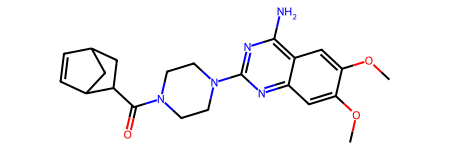

In [ ]:
Chem.MolFromSmiles(filtered_df['canonical_smiles'].iloc[0])

In [ ]:
# Select relevant columns for analysis
properties = [
    'mw_freebase', 'alogp', 'hba', 'hbd', 'rtb', 'psa',
    'heavy_atoms', 'qed_weighted', 'num_lipinski_ro5_violations'
]

# Display statistical summary
filtered_df[properties].describe()


,mw_freebase,alogp,hba,hbd,rtb,psa,heavy_atoms,qed_weighted,num_lipinski_ro5_violations
count,154755.000000,154755.000000,154755.000000,154755.000000,154755.000000,154755.000000,154755.000000,154755.000000,154755.0
mean,335.476214,2.966293,4.048981,1.077516,4.038422,62.119279,23.620180,0.829884,0.0
std,38.910647,0.941185,1.339861,0.681613,1.504759,20.764985,2.593326,0.050478,0.0
min,259.310000,-0.400000,0.000000,0.000000,0.000000,3.240000,20.000000,0.760000,0.0
25%,305.360000,2.350000,3.000000,1.000000,3.000000,47.560000,22.000000,0.790000,0.0
50%,332.400000,3.030000,4.000000,1.000000,4.000000,62.120000,23.000000,0.820000,0.0
75%,362.480000,3.660000,5.000000,1.000000,5.000000,76.040000,25.000000,0.870000,0.0
max,463.510000,5.000000,10.000000,3.000000,9.000000,139.820000,33.000000,0.950000,0.0


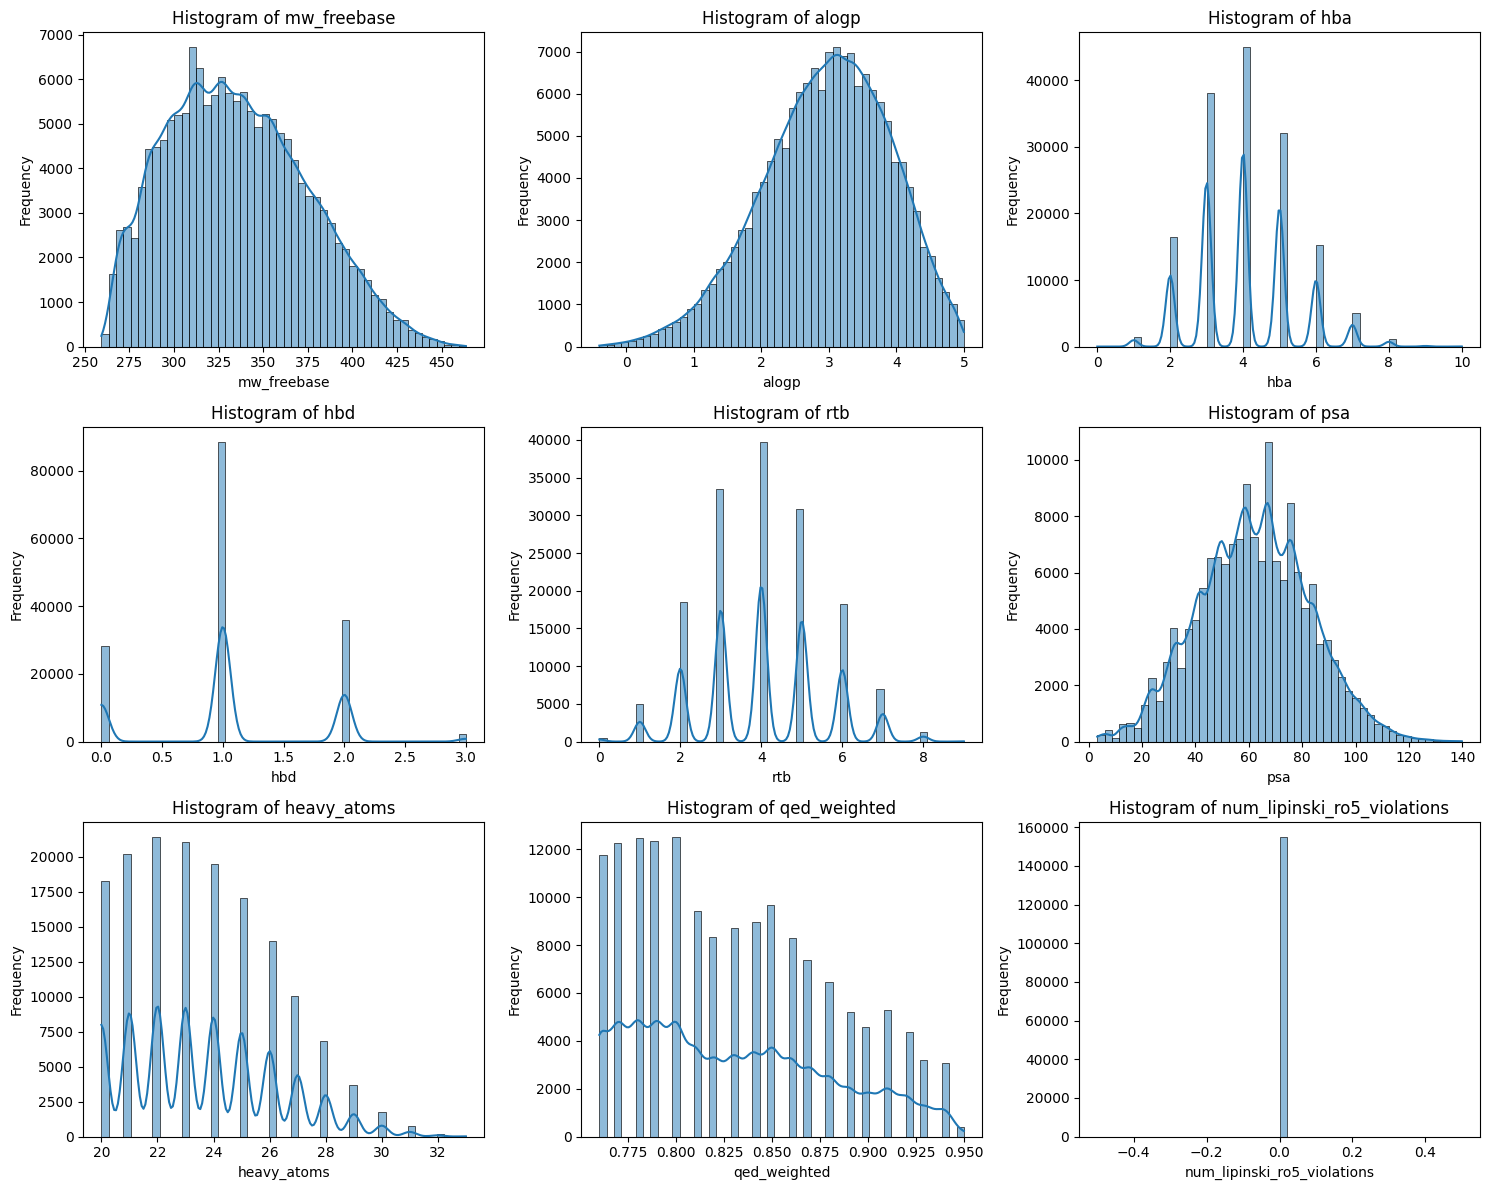

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

for i, prop in enumerate(properties, 1):
    plt.subplot(3, 3, i)
    sns.histplot(filtered_df[prop], kde=True, bins=50)
    plt.title(f'Histogram of {prop}')
    plt.xlabel(prop)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


[18:22:49] WARNING: not removing hydrogen atom without neighbors
<ipython-input-43-58e69e5df790>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elements'] = filtered_df['canonical_smiles'].apply(get_elements)


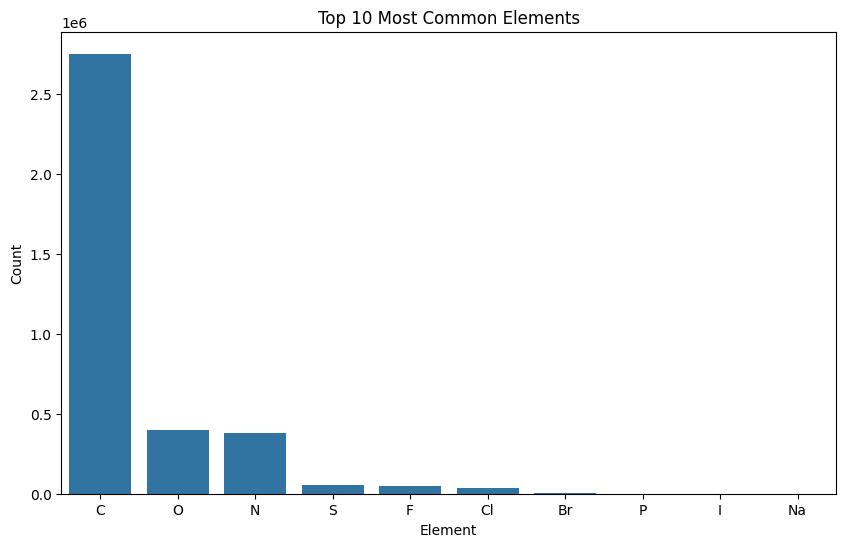

In [ ]:
from collections import Counter

def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()] if mol else []
    return elements

# Extract elements from all molecules
filtered_df['elements'] = filtered_df['canonical_smiles'].apply(get_elements)

# Flatten the list of elements and count occurrences
all_elements = [elem for sublist in filtered_df['elements'] for elem in sublist]
element_counts = Counter(all_elements)

# Get the top 10 most common elements
top_elements = element_counts.most_common(10)
elements, counts = zip(*top_elements)

# Plot the element distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(elements), y=list(counts))
plt.title('Top 10 Most Common Elements')
plt.xlabel('Element')
plt.ylabel('Count')
plt.show()


Epoch 1/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 329s 448ms/step - accuracy: 0.8544 - loss: 0.5310 - val_accuracy: 0.9309 - val_loss: 0.2063
Epoch 2/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9314 - loss: 0.2032 - val_accuracy: 0.9414 - val_loss: 0.1696
Epoch 3/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9392 - loss: 0.1758 - val_accuracy: 0.9435 - val_loss: 0.1619
Epoch 4/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9423 - loss: 0.1654 - val_accuracy: 0.9466 - val_loss: 0.1515
Epoch 5/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9448 - loss: 0.1572 - val_accuracy: 0.9477 - val_loss: 0.1473
Epoch 6/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9461 - loss: 0.1528 - val_accuracy: 0.9492 - val_loss: 0.1440
Epoch 7/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9474 - loss: 0.1485 - val_accuracy: 0.9499 - val_loss: 0.1412
Epoch 8/60
484/484 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9484 - loss: 0.1456 

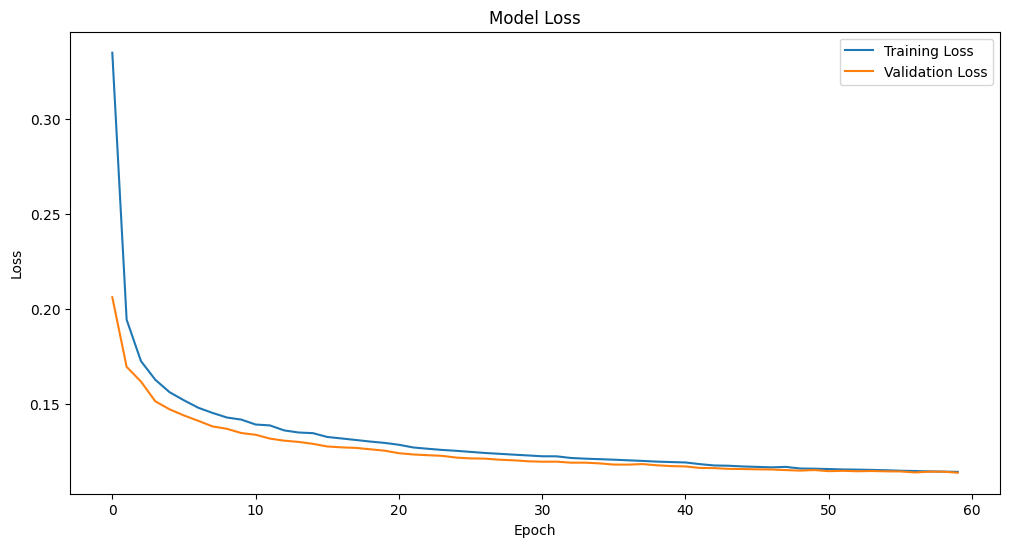

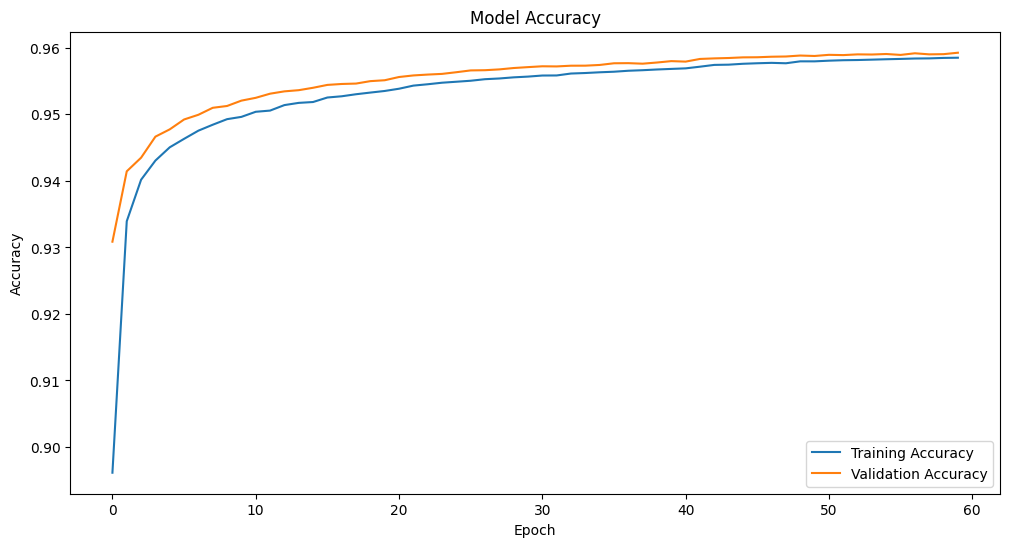

In [ ]:
# Decoder only

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 128
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 60
BATCH_SIZE = 256  # Adjust based on memory availability
LEARNING_RATE = 1e-3
NUM_LAYERS = 8
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Prepare SMILES strings
smiles_list = filtered_df['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in smiles_list
]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Build the GPT-like decoder-only model
def build_decoder_only_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], model_dim)
    x = Add()([x, pos_encoding[:, :input_shape[0], :]])

    for _ in range(num_layers):
        # Decoder block
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x, attention_mask=tf.linalg.band_part(tf.ones((input_shape[0], input_shape[0])), -1, 0))
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)
    model = Model(inputs, outputs)
    return model

# Instantiate the model
decoder_only_model = build_decoder_only_model(
    input_shape=(max_length,),
    vocab_size=len(vocab),
    model_dim=MODEL_DIM,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT,
    num_layers=NUM_LAYERS
)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

decoder_only_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = decoder_only_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)

        # Append the next character to the sequence
        input_seq.append(next_char)

        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break

    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list, training_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique_smiles = list(set(valid_smiles))
    not_unique = 0
    for smiles in training_smiles_list:
      if smiles in unique_smiles:
        not_unique += 1

    # percent unique = number found in training set - unique smiles / total valid smiles
    unique = (len(unique_smiles)-not_unique)/len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

O=C(Nc1ccc2ccccc2c1)Nc1cccc(F)c1
Generated SMILES: O=C(Nc1ccc2ccccc2c1)Nc1cccc(F)c1


  1%|          | 1/100 [00:02<04:23,  2.66s/it]

NS(=O)(=O)c1ccc(-c2cs3c(c2)c(C(=O)O)CCCC3)cc1


  2%|▏         | 2/100 [00:04<03:48,  2.33s/it]

Cc1ccccc1Nc1ncc(Cc2ccc(O)c(Br)c2)s1


  3%|▎         | 3/100 [00:07<03:49,  2.37s/it]

CS(=O)(=O)N1CCC[C@@]2(CCN(c3ncccn3)C2)C1


  4%|▍         | 4/100 [00:09<03:48,  2.38s/it]

CS(=O)(=O)Nc1cc(-c2csc(-c3ccno3)n2)ccc1Cl


  5%|▌         | 5/100 [00:11<03:45,  2.38s/it]

CC1=COC(C(=O)Nc2cccn(-c3ccccc3)c2=O)C=C1


  6%|▌         | 6/100 [00:13<03:31,  2.25s/it]

COc1ccc(-c2ccc3nc(C(N)=O)cn3c2)cc1


  7%|▋         | 7/100 [00:16<03:31,  2.27s/it]

CC(=O)OC(C)(CC(=O)Nc1ccc(Cl)cc1)c1ccccc1


  8%|▊         | 8/100 [00:18<03:28,  2.26s/it]

CCc1ccc(NC(=O)C2CSC3(C)CC(=O)N2C3)cc1


  9%|▉         | 9/100 [00:20<03:21,  2.21s/it]

CC(C)c1ccc(NC(=O)CN(C)Cc2ccccc2)cc1


 10%|█         | 10/100 [00:22<03:11,  2.13s/it]

O=C(NCCN1CCN(c2ccccc2)CC1)c1cccs1


 11%|█         | 11/100 [00:24<03:12,  2.17s/it]

CC(C)c1ncn(C)c1C(=O)Nc1nc(-c2cccs2)cs1


 12%|█▏        | 12/100 [00:27<03:29,  2.38s/it]

C[C@@H](NC(=O)c1nc(C(F)(F)F)nn1-c1ccccc1)c1ccccc1


 13%|█▎        | 13/100 [00:30<03:43,  2.57s/it]

CC(=O)N1c2ccc(S(=O)(=O)N3CCC(N4CCC(O)CC4)CC3)cc2CC1C


 14%|█▍        | 14/100 [00:32<03:29,  2.44s/it]

CC(C)c1ccc(CNC(=O)C2CC1c1ccccc1)cc1


 15%|█▌        | 15/100 [00:34<03:19,  2.34s/it]

CCNCC1CCN(c2ccccc2NC(=O)c2cnccn2)C1


 16%|█▌        | 16/100 [00:37<03:21,  2.40s/it]

COc1cc(OC)cc(C(=O)Nc2nc(-c3cccc(C)n3)cs2)c1


 17%|█▋        | 17/100 [00:39<03:12,  2.32s/it]

CC(C)C(COc1ccccc1)OC(=O)c1ccc(Cl)nc1


 18%|█▊        | 18/100 [00:42<03:29,  2.55s/it]

CC(C)Cn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCCC(C(N)=O)C3)cc21


 19%|█▉        | 19/100 [00:45<03:42,  2.75s/it]

COC(=O)[C@@H]1CCCO[C@@H]1C(=O)Nc1ccc(-c2nc(C)c[nH]2)cc1


 20%|██        | 20/100 [00:48<03:25,  2.57s/it]

CC1=O)C(=O)C2=C(C1)NC(Nc1cc(F)ccc1F


 21%|██        | 21/100 [00:50<03:08,  2.39s/it]

CC1CCCN(C(=O)c2nnnn2-c2ccccc2F)C1


 22%|██▏       | 22/100 [00:52<03:09,  2.43s/it]

O=C(COc1ccc(CNS(=O)(=O)c2ccccc2)cc1)NC1CCC1


 23%|██▎       | 23/100 [00:55<03:08,  2.45s/it]

COc1ccc(C2CC(=O)Nc3c2c(=O)n(C)c(=O)n3C)cc1


 24%|██▍       | 24/100 [00:56<02:49,  2.23s/it]

CN1CCN(c2nc3ccccc3c(=O)o2)CC1


 25%|██▌       | 25/100 [00:59<02:49,  2.25s/it]

CC(=O)N1CCN(C(=O)C2(N3CCCCC3)CCCCC2)CC1


 26%|██▌       | 26/100 [01:01<02:57,  2.40s/it]

COc1cc(C)c(C2(O)CC(=O)c3c(O)cc(OC)cc3O2)cc1OC


 27%|██▋       | 27/100 [01:03<02:35,  2.13s/it]

COc1ccccc1CN1CCNC(=O)C1=O


 28%|██▊       | 28/100 [01:05<02:38,  2.20s/it]

C=CCNN1CCc2cc(Cl)c(O)cc2[C@H]1c1nc(C)cs1


 29%|██▉       | 29/100 [01:08<02:41,  2.27s/it]

Cc1cc(C)n(C2CCCc3c2cnn3-c2ccc(F)c(F)c2F)n1


 30%|███       | 30/100 [01:10<02:36,  2.24s/it]

COc1ccc(NC(=O)CN2C(=O)COc3ccccc32)cc1


 31%|███       | 31/100 [01:12<02:39,  2.32s/it]

CCOC(=O)N1CCC(N2CCN(Cc3ccccn3)C(CCO)C2)CC1


 32%|███▏      | 32/100 [01:15<02:45,  2.43s/it]

CC1=C2N=C(S)N(c3ccc(F)cc3)C2(N)C(=O)c2ccccc21


 33%|███▎      | 33/100 [01:17<02:33,  2.29s/it]

O=C(Nc1ccc(Cl)cc1)N1CCN=C1c1cccs1


 34%|███▍      | 34/100 [01:20<02:40,  2.44s/it]

COc1ccc(C(=O)Nc2sc3c(c2C(N)=O)CCN(C(N)=O)C3)cc1


 35%|███▌      | 35/100 [01:22<02:28,  2.29s/it]

CCc1ccc(/C=C/C(=O)NCCc2cccnc2)cc1


 36%|███▌      | 36/100 [01:25<02:43,  2.55s/it]

COc1cc(OC)cc([C@@H]2C[C@H](C(=O)Nc3cccc(N)n3)CN2C#N)c1


 37%|███▋      | 37/100 [01:27<02:30,  2.39s/it]

COc1ccc(Cl)cc1NC(=O)c1cc2ccccc2s1


 38%|███▊      | 38/100 [01:29<02:24,  2.33s/it]

CC(C)C12CC3CC(C)(C3)C1NC(=O)c1ccccc12


 39%|███▉      | 39/100 [01:31<02:15,  2.21s/it]

CCN(CC)S(=O)(=O)c1ccc2c(c1)CCCC2C


 40%|████      | 40/100 [01:34<02:29,  2.48s/it]

O=C(CN1CCN(c2ccccc2F)CC1)Nc1cc(Cl)ccc1Cl.O=C(O)C(=O)O


 41%|████      | 41/100 [01:37<02:35,  2.64s/it]

Cc1ccc(CN2CCC(n3nccc3NC(=O)C3CC3)CC2)cc1


 42%|████▏     | 42/100 [01:40<02:30,  2.60s/it]

CCCCN(C)CCOc1ccc2c(c1)NC(=O)C1=C2N=C(N)CN1


 43%|████▎     | 43/100 [01:42<02:26,  2.58s/it]

CN(CCN1CCN(C)CC1)C(=O)N1CCC(Nc2ccccc2)CC1


 44%|████▍     | 44/100 [01:44<02:17,  2.46s/it]

CC(=O)N1c2ccc(Nc3nc(C)cc(C)n3)cc2CC1C


 45%|████▌     | 45/100 [01:46<02:08,  2.33s/it]

CFc1ccc(Nc2nc(N)c3c(n2)CCCC3=O)cc1


 46%|████▌     | 46/100 [01:49<02:08,  2.39s/it]

COc1ccc(NC(=O)N2CCN(c3cccc(Cl)c3Cl)CC2)cc1


 47%|████▋     | 47/100 [01:52<02:23,  2.70s/it]

CC(C)(C)COC(=O)C1=C(CC(=O)O)Cc2cc(Cl)c(F)cc2C1(Br)c1cccnc1


 48%|████▊     | 48/100 [01:55<02:18,  2.67s/it]

CS(=O)(=O)c1ccc(Cl)c(C#Cc2ccc(Cl)c(Cl)c2)c1


 49%|████▉     | 49/100 [01:58<02:21,  2.77s/it]

C[C@H](c1nc2ccccc2n1C)N1CCC2(CC1)OCCc1cc2c(cc1-2)O


 50%|█████     | 50/100 [02:00<02:09,  2.60s/it]

CC1CCCN(C(=O)c2ccccc2NC(=O)c2ccco2)C1


 51%|█████     | 51/100 [02:02<02:01,  2.48s/it]

CS(=O)(=O)N/N=C1/c2ccccc2CCc2ccccc21


 52%|█████▏    | 52/100 [02:05<02:05,  2.62s/it]

CN1C(=O)[C@@](c2ccc(F)cc2)(c2ccc3c(c2)OCCO3)N=C1N


 53%|█████▎    | 53/100 [02:07<01:50,  2.35s/it]

CCSc1nc2c3c(c(N)nc2sc1C)CCCC3


 54%|█████▍    | 54/100 [02:09<01:49,  2.38s/it]

NS(=O)(=O)c1ccc(NC(=S)NC(=O)C(F)(F)F)cc1


 55%|█████▌    | 55/100 [02:12<01:45,  2.34s/it]

CS(=O)(=O)N(CC(=O)NCc1ccccc1)c1ccccc1


 56%|█████▌    | 56/100 [02:14<01:46,  2.43s/it]

CC1=NN(C(=O)COC(=O)c2cccc(Br)c2)C(c2ccccc2)C1


 57%|█████▋    | 57/100 [02:17<01:52,  2.61s/it]

COc1ccc(CN2CCC(C(=O)NCc3ccccc3F)CC2)cc1.O=C(O)C(=O)O


 58%|█████▊    | 58/100 [02:20<01:45,  2.52s/it]

CCOc1ccc(NC(=O)C(C)OC(=O)C2=COCCO2)cc1


 59%|█████▉    | 59/100 [02:22<01:39,  2.43s/it]

O=C1NCN(c2ccccc2)C12CCN(C1CCCCC1)CC2


 60%|██████    | 60/100 [02:24<01:37,  2.44s/it]

O=C(NCCc1ccc(Cl)cc1)N1CCC(N2CCC(CO)CC2)CC1


 61%|██████    | 61/100 [02:27<01:34,  2.42s/it]

O=C1CCN(C(=O)CC1SCc2ccccc2C1=O)c1ccccc1


 62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]

COc1cc2c(cc1OC)C(CCNC(C)=O)=NC(C)(C)C2


 63%|██████▎   | 63/100 [02:31<01:25,  2.31s/it]

Cc1cccc2c1CCCN2S(=O)(=O)c1cc(C)ccc1Cl


 64%|██████▍   | 64/100 [02:34<01:33,  2.59s/it]

CCO[C@H]1Oc2ccc3c(CCN(C)CC)c(=O)cccc3c2[C@@H](C)C1(C)C


 65%|██████▌   | 65/100 [02:37<01:29,  2.56s/it]

C[C@@H]1CN(CCCOc2cccc(Cl)c2)CCN1Cc1ccccc1


 66%|██████▌   | 66/100 [02:39<01:24,  2.48s/it]

Cc1ccc(NC(=O)COC(=O)c2ccc3c(c2)OCO3)cc1


 67%|██████▋   | 67/100 [02:41<01:15,  2.28s/it]

CCCCCCc1cc(NC)c(OC)c(C(C)C)c1C


 68%|██████▊   | 68/100 [02:43<01:15,  2.36s/it]

O=C1CN(S(=O)(=O)c2ccccc2)CCN1Cc1c(F)cccc1F


 69%|██████▉   | 69/100 [02:46<01:14,  2.41s/it]

COc1ccc(NC(=O)CSc2nc3c(cc2C#N)C(=O)CCO3)cn1


 70%|███████   | 70/100 [02:49<01:16,  2.54s/it]

N#CC1=C(N)OC2=C(C(=O)C(=O)c3ccccc32)C1c1ccccc1


 71%|███████   | 71/100 [02:52<01:15,  2.62s/it]

CCN(CC)S(=O)(=O)N1CCc2ccc(NC(=O)N3CCOCC3)cc2C1


 72%|███████▏  | 72/100 [02:53<01:05,  2.34s/it]

CN(Cc1ccccc1F)C(=S)NC1CCCCC1


 73%|███████▎  | 73/100 [02:56<01:03,  2.36s/it]

NC(=O)COc1cc2c(c3c1CCC3)CCN(Cc1ccccc1)C2


 74%|███████▍  | 74/100 [02:59<01:10,  2.70s/it]

CS(=O)(=O)N1c2ccc(F)cc2CCN1C(=O)N[C@H](C(=O)O)c1ccc(Cl)cc1


 75%|███████▌  | 75/100 [03:03<01:13,  2.93s/it]

CC(C)(C)OC(=O)NC(=O)N1[C@@H](CC(=O)NCc2ccccc2F)C[C@@H]1C#N


 76%|███████▌  | 76/100 [03:05<01:05,  2.73s/it]

COc1ccc2c(c1)NC(=O)C(Oc1ccc(F)cc1)O2


 77%|███████▋  | 77/100 [03:09<01:09,  3.01s/it]

O=C(c1ccccc1)N1CC[C@H]2[C@H](C1)[C@@H]1c3n[(@H]c4ccccc34)CCN12


 78%|███████▊  | 78/100 [03:10<00:58,  2.66s/it]

COc1cccc(Nc2nccc(-c3ccco3)n2)c1


 79%|███████▉  | 79/100 [03:13<00:55,  2.66s/it]

CCC(OC(=O)c1cccc(C(F)(F)F)c1Cl)C(=O)NC1CCCC1


 80%|████████  | 80/100 [03:16<00:52,  2.62s/it]

Cc1nc(NC2CCC(O)CC2)c2c(-c3ccccc3)sc(C)c2n1


 81%|████████  | 81/100 [03:18<00:47,  2.48s/it]

NC1=NC(c2ccccc2)C(OC(=O)C2=COCCO2)N1


 82%|████████▏ | 82/100 [03:20<00:42,  2.35s/it]

CCOc1ccc(CN2CCN(c3ccccn3)CC2)cc1OC


 83%|████████▎ | 83/100 [03:23<00:44,  2.62s/it]

O=C1NC(=O)C(c2ccc(S(=O)(=O)Nc3ccc(F)cc3)cc2)=C1c1ccccn1


 84%|████████▍ | 84/100 [03:25<00:40,  2.50s/it]

N#Cc1ccc(OCc2ccc(Br)cc2)c(CN2CCCCC2)c1


 85%|████████▌ | 85/100 [03:29<00:41,  2.74s/it]

CCN1C(=O)C(O)(C2=C(c3ccccc3)C3(CCCC3)CCCCC2=O)c2ccccc21


 86%|████████▌ | 86/100 [03:31<00:35,  2.50s/it]

Clc1ccc(N2CCC(NCCc3ccco3)CC2)cc1


 87%|████████▋ | 87/100 [03:34<00:34,  2.63s/it]

CCC(=O)N1Cc2cc(C(=O)NC3CCCc4ccccc43)ccc2N=C(N)C1=O


 88%|████████▊ | 88/100 [03:36<00:29,  2.48s/it]

S=C(NC1CCCC1)N1CCN(c2ncc(Br)cn2)CC1


 89%|████████▉ | 89/100 [03:38<00:26,  2.41s/it]

COc1ccc2c(c1O)-c1c(cc(OC)c(OC)c1OC)CC2


 90%|█████████ | 90/100 [03:40<00:24,  2.42s/it]

CCOc1ccc2oc(C(=O)N3CCC(C(N)=O)CC3)c(C)c2c1


 91%|█████████ | 91/100 [03:43<00:21,  2.39s/it]

CN(C)c1ccc(/N=C2\C(=O)c3ccccc3C2=O)cc1


 92%|█████████▏| 92/100 [03:45<00:20,  2.52s/it]

Cc1ccccc1NCC(=O)N1CCN(C2CC3C=CC(C2)C3C(=O)O)CC1


 93%|█████████▎| 93/100 [03:48<00:17,  2.50s/it]

O=C(c1cc(Cc2ccccc2)on1)N1CCN(c2ccccc2F)CC1


 94%|█████████▍| 94/100 [03:50<00:14,  2.40s/it]

COc1ccccc1-c1csc(N2CCC(C(N)=O)CC2)n1


 95%|█████████▌| 95/100 [03:53<00:12,  2.48s/it]

O=C(CCN(CC1CCCO1)c1ccc(F)c(F)c1)Nc1ccc(Cl)cn1


 96%|█████████▌| 96/100 [03:56<00:11,  2.83s/it]

CC(=O)[C@H]1[C@H]1CN(C)[C@@H](C(=O)N2CCC(Cc3ccccc3)CC2)CN1.Cl


 97%|█████████▋| 97/100 [03:59<00:08,  2.70s/it]

Cl.NC1=NC(c2ccccc2)=NCN1Cc1ccc2c(c1)CCO2


 98%|█████████▊| 98/100 [04:01<00:04,  2.44s/it]

O=C(CSc1nncn1C1CC1)Nc1cccc(F)c1


 99%|█████████▉| 99/100 [04:03<00:02,  2.53s/it]

COc1ccc(OC)c(S(=O)(=O)NCc2cc(OC)c(OC)c(OC)c2)c1


100%|██████████| 100/100 [04:06<00:00,  2.46s/it]

Cc1cc(C)c2oc(C(=O)NCc3ccco3)c(C)c2c1



Percent valid: 92.000%
Percent unique: 95.652%
['O=C(NCCc1ccc(Cl)cc1)N1CCC(N2CCC(CO)CC2)CC1', 'O=C(CSc1nncn1C1CC1)Nc1cccc(F)c1', 'COc1ccccc1-c1csc(N2CCC(C(N)=O)CC2)n1', 'CC(=O)N1c2ccc(S(=O)(=O)N3CCC(N4CCC(O)CC4)CC3)cc2CC1C', 'NS(=O)(=O)c1ccc(-c2cs3c(c2)c(C(=O)O)CCCC3)cc1', 'Cc1nc(NC2CCC(O)CC2)c2c(-c3ccccc3)sc(C)c2n1', 'Clc1ccc(N2CCC(NCCc3ccco3)CC2)cc1', 'O=C(c1cc(Cc2ccccc2)on1)N1CCN(c2ccccc2F)CC1', 'CC(C)C12CC3CC(C)(C3)C1NC(=O)c1ccccc12', 'CCOc1ccc(CN2CCN(c3ccccn3)CC2)cc1OC', 'CCCCN(C)CCOc1ccc2c(c1)NC(=O)C1=C2N=C(N)CN1', 'CN1CCN(c2nc3ccccc3c(=O)o2)CC1', 'Cc1cc(C)n(C2CCCc3c2cnn3-c2ccc(F)c(F)c2F)n1', 'CN(Cc1ccccc1F)C(=S)NC1CCCCC1', 'C[C@@H](NC(=O)c1nc(C(F)(F)F)nn1-c1ccccc1)c1ccccc1', 'CCCCCCc1cc(NC)c(OC)c(C(C)C)c1C', 'CC1=C2N=C(S)N(c3ccc(F)cc3)C2(N)C(=O)c2ccccc21', 'O=C1NCN(c2ccccc2)C12CCN(C1CCCCC1)CC2', 'COc1cc(OC)cc(C(=O)Nc2nc(-c3cccc(C)n3)cs2)c1', 'CCOc1ccc(NC(=O)C(C)OC(=O)C2=COCCO2)cc1', 'Cc1ccc(NC(=O)COC(=O)c2ccc3c(c2)OCO3)cc1', 'CC(C)Cn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCCC(C(N)=O)C3)cc2

In [ ]:
decoder_only_model.save("/content/drive/MyDrive/models/SMILES_Gen/TD_128_L8_H4.keras")

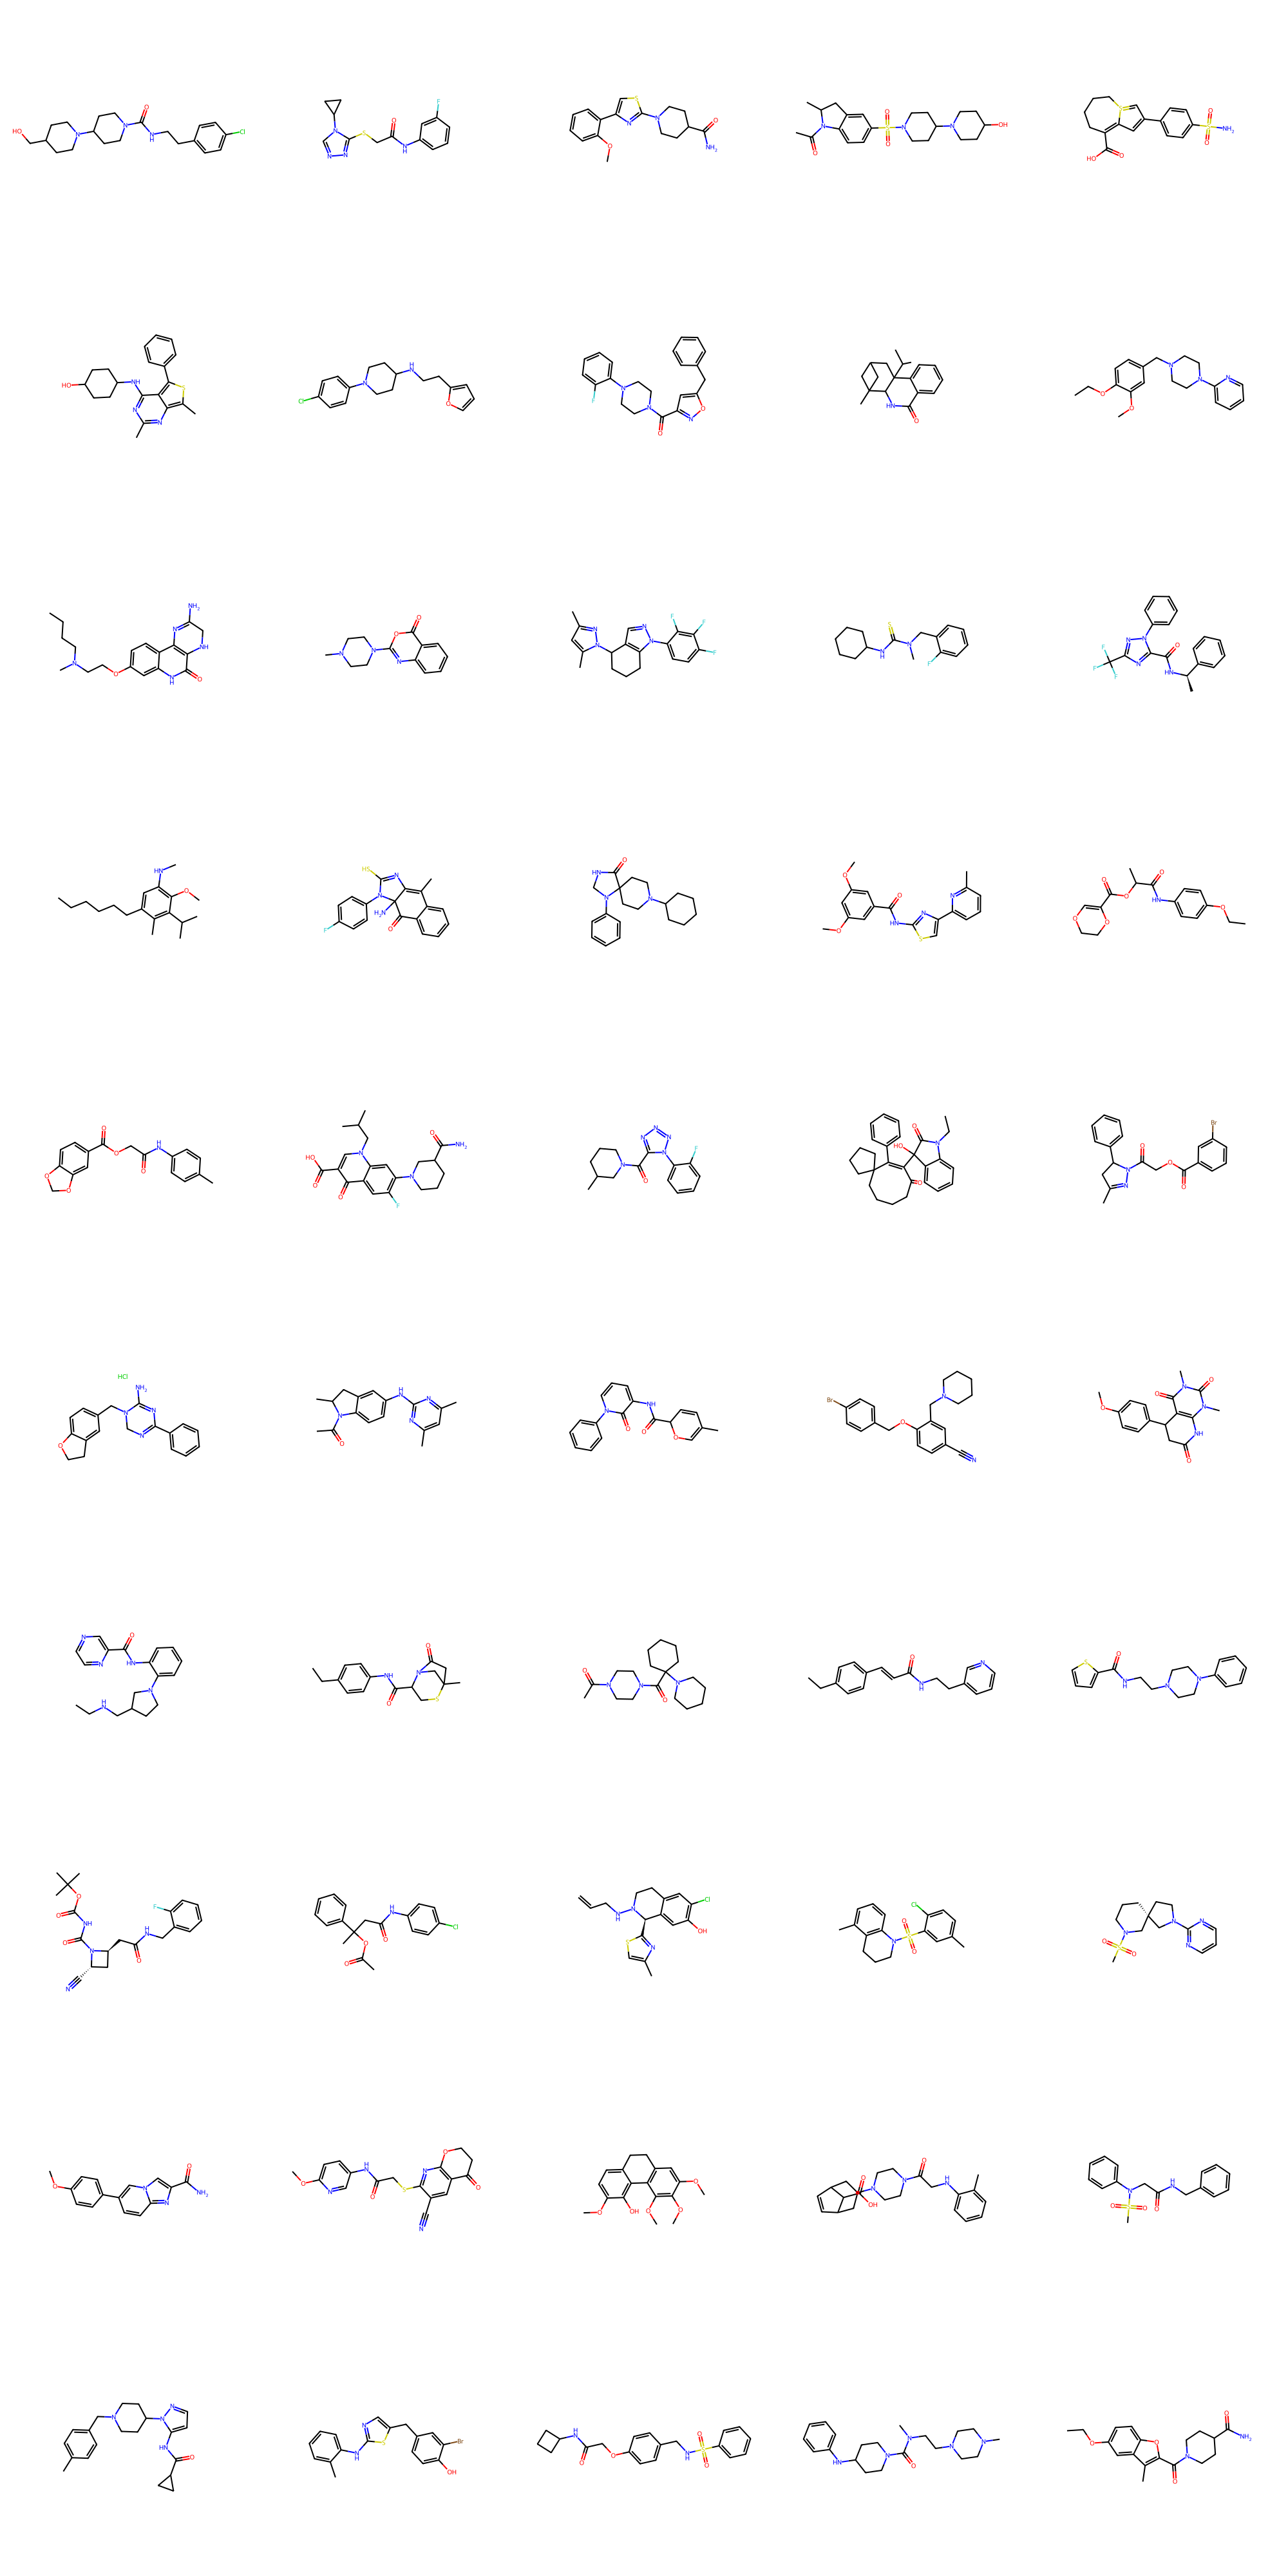

In [ ]:
# Display the first 10 unique valid SMILES strings as a grid image
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in unique_valid_smiles[:50]]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)

[19:35:28] WARNING: not removing hydrogen atom without neighbors
[19:35:28] WARNING: not removing hydrogen atom without neighbors


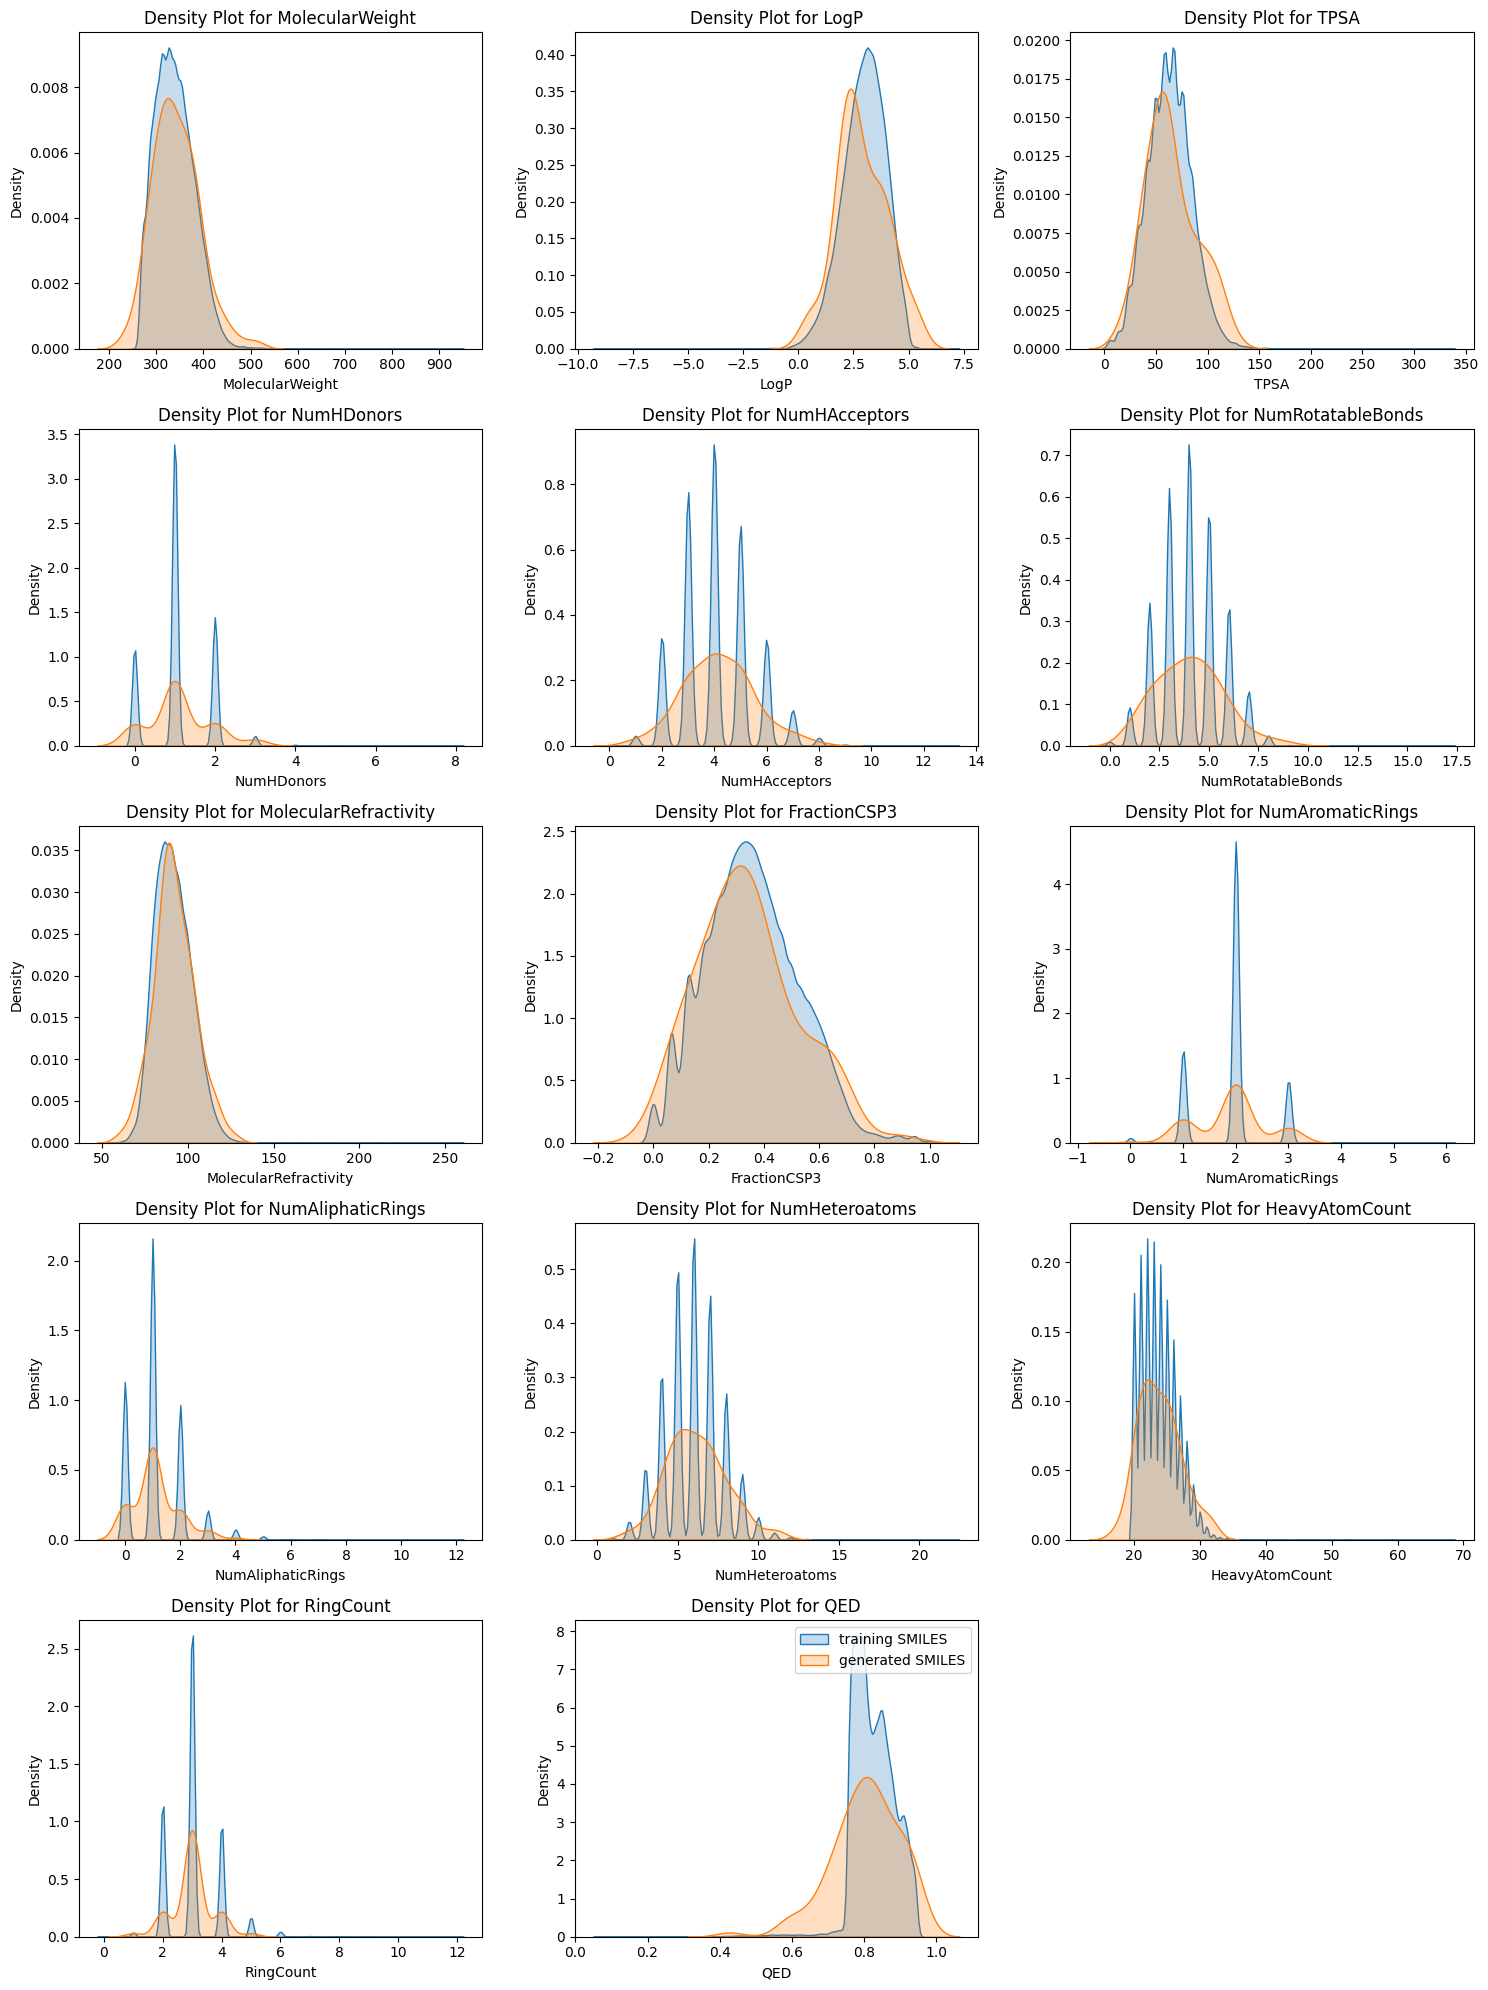

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors


# Define a function to compute descriptors for a given SMILES string
def compute_descriptors(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is not None:
        return {
            # Molecular Weight: The sum of atomic weights in the molecule.
            'MolecularWeight': Descriptors.MolWt(molecule),

            # LogP: The logarithm of the octanol-water partition coefficient, indicating hydrophobicity.
            'LogP': Descriptors.MolLogP(molecule),

            # Topological Polar Surface Area (TPSA): The surface area of polar atoms, associated with drug absorption.
            'TPSA': Descriptors.TPSA(molecule),

            # Number of Hydrogen Bond Donors: Atoms in the molecule that can donate hydrogen bonds (e.g., -OH, -NH).
            'NumHDonors': Descriptors.NumHDonors(molecule),

            # Number of Hydrogen Bond Acceptors: Atoms in the molecule that can accept hydrogen bonds (e.g., O, N).
            'NumHAcceptors': Descriptors.NumHAcceptors(molecule),

            # Number of Rotatable Bonds: Single bonds that allow free rotation, contributing to molecular flexibility.
            'NumRotatableBonds': Descriptors.NumRotatableBonds(molecule),

            # Molecular Refractivity: Related to the molecule's polarizability and volume.
            'MolecularRefractivity': Descriptors.MolMR(molecule),

            # Fraction of sp3 Carbons (Csp3): The ratio of sp3-hybridized carbons to the total number of carbons.
            'FractionCSP3': Descriptors.FractionCSP3(molecule),

            # Number of Aromatic Rings: Counts the number of rings with delocalized pi-electron systems.
            'NumAromaticRings': Descriptors.NumAromaticRings(molecule),

            # Number of Aliphatic Rings: Counts the number of non-aromatic cyclic structures.
            'NumAliphaticRings': Descriptors.NumAliphaticRings(molecule),

            # Number of Heteroatoms: Atoms other than carbon and hydrogen (e.g., N, O, S).
            'NumHeteroatoms': Descriptors.NumHeteroatoms(molecule),

            # Number of Heavy Atoms: Atoms in the molecule that are not hydrogen.
            'HeavyAtomCount': Descriptors.HeavyAtomCount(molecule),

            # Total Number of Rings: Counts all rings in the molecule, both aromatic and aliphatic.
            'RingCount': Descriptors.RingCount(molecule),

            # Calculated QED
            'QED': Chem.QED.qed(molecule)
        }
    else:
        # Return NaNs or a default value for invalid SMILES strings
        return {
            'MolecularWeight': float('nan'),
            'LogP': float('nan'),
            'TPSA': float('nan'),
            'NumHDonors': float('nan'),
            'NumHAcceptors': float('nan'),
            'NumRotatableBonds': float('nan'),
            'MolecularRefractivity': float('nan'),
            'FractionCSP3': float('nan'),
            'NumAromaticRings': float('nan'),
            'NumAliphaticRings': float('nan'),
            'NumHeteroatoms': float('nan'),
            'HeavyAtomCount': float('nan'),
            'RingCount': float('nan'),
            'QED': float('nan')
        }

# Create dataframes from generated SMILES data to store molecular descriptors
training_df = pd.DataFrame(smiles_list, columns=['SMILES'])
generated_df = pd.DataFrame(unique_valid_smiles, columns=['SMILES'])

# Apply the descriptor function to each row in the dataframe
descriptor_columns = training_df['SMILES'].apply(compute_descriptors)
descriptor_columns_gen = generated_df['SMILES'].apply(compute_descriptors)

# Convert the series of dictionaries into a DataFrame
descriptors_df = pd.DataFrame(descriptor_columns.tolist())
descriptors_gen_df = pd.DataFrame(descriptor_columns_gen.tolist())

# Merge the descriptors back into the original dataframe
training_data = pd.concat([training_df, descriptors_df], axis=1)
gen_data = pd.concat([generated_df, descriptors_gen_df], axis=1)

# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

descriptor_cols = descriptors_df.columns.to_list()

# Loop through the columns and create a density plot for each
for i, column in enumerate(descriptor_cols, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(training_data[column], fill=True, label='training SMILES')
    sns.kdeplot(gen_data[column], fill=True, label='generated SMILES')
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
plt.show()


[BindingBD](https://www.bindingdb.org/rwd/jsp/dbsearch/PrimarySearch_ki.jsp?target=Cystic+fibrosis+transmembrane+conductance+regulator&tag=tg&kiunit=nM&icunit=nM&column=ki&submit=Search&energyterm=kJ%2Fmole) Used for collecting compounds for cystic fibrosis transmembrane conductance regulator.

For citing:

  BindingDB in 2015: A public database for medicinal chemistry, computational chemistry and systems pharmacology. M.K. Gilson, T. Liu, M. Baitaluk, G. Nicola, L. Hwang and J. Chong Nucleic Acids Research 44:D0145-D1053, doi: 10.1093/nar/gkv1072

In [ ]:
model_path = "/content/drive/MyDrive/models/SMILES_Gen/TD_128_L8_H4.keras"
model = tf.keras.models.load_model(model_path)

# Load and preprocess the fine-tuning dataset
#
fine_tuning_data = pd.read_csv("/content/drive/MyDrive/Datasets/chemdata/BindingDB/cystic_fibrosis.tsv", delimiter='\t')
fine_tuning_smiles_list = fine_tuning_data['Ligand SMILES'].drop_duplicates().tolist()

# Encode and pad the fine-tuning SMILES strings
encoded_fine_tuning_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index.get(char, chars_to_index['<PAD>']) for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in fine_tuning_smiles_list
]
padded_fine_tuning_smiles_list = pad_sequences(encoded_fine_tuning_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X_fine_tune = np.array(padded_fine_tuning_smiles_list)

# Create target sequences for fine-tuning
y_fine_tune = np.zeros_like(X_fine_tune)
y_fine_tune[:, :-1] = X_fine_tune[:, 1:]
y_fine_tune[:, -1] = chars_to_index['<PAD>']

# Optionally split into training and validation sets
X_fine_tune_train, X_fine_tune_val, y_fine_tune_train, y_fine_tune_val = train_test_split(X_fine_tune, y_fine_tune, test_size=0.2, random_state=42)


In [ ]:
# Compile the model with a lower learning rate for fine-tuning
fine_tune_optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=1e-4,  # Lower learning rate for fine-tuning
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

model.compile(loss='sparse_categorical_crossentropy', optimizer=fine_tune_optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 203s 9s/step - accuracy: 0.8829 - loss: 0.4723 - val_accuracy: 0.8989 - val_loss: 0.3489
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9016 - loss: 0.3294 - val_accuracy: 0.9135 - val_loss: 0.2896
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9139 - loss: 0.2765 - val_accuracy: 0.9211 - val_loss: 0.2551
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9194 - loss: 0.2532 - val_accuracy: 0.9275 - val_loss: 0.2309
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9272 - loss: 0.2252 - val_accuracy: 0.9326 - val_loss: 0.2136
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9315 - loss: 0.2098 - val_accuracy: 0.9356 - val_loss: 0.1999
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9336 - loss: 0.2019 - val_accuracy: 0.9394 - val_loss: 0.1897
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9393 - loss: 0.1863 - val_accuracy: 0.9431 - v

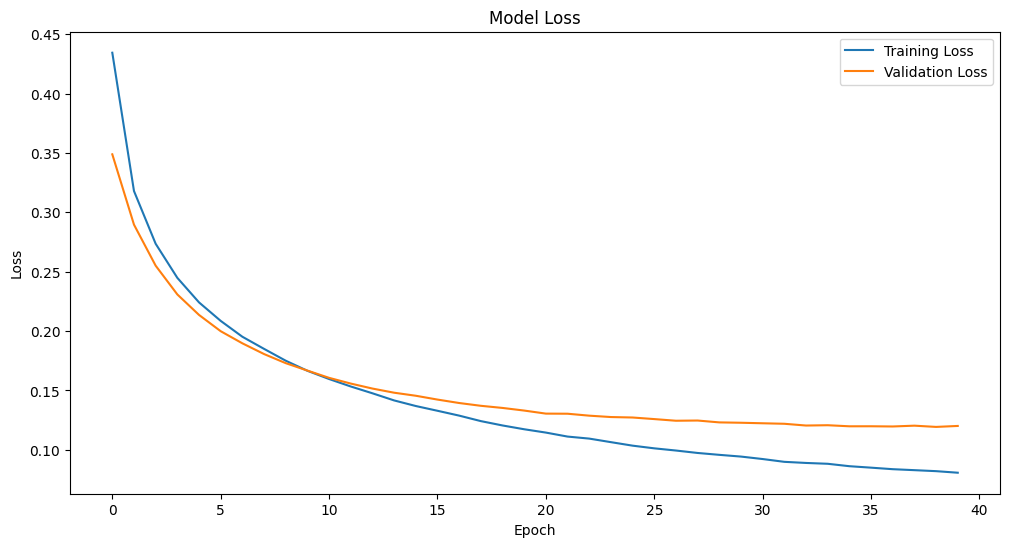

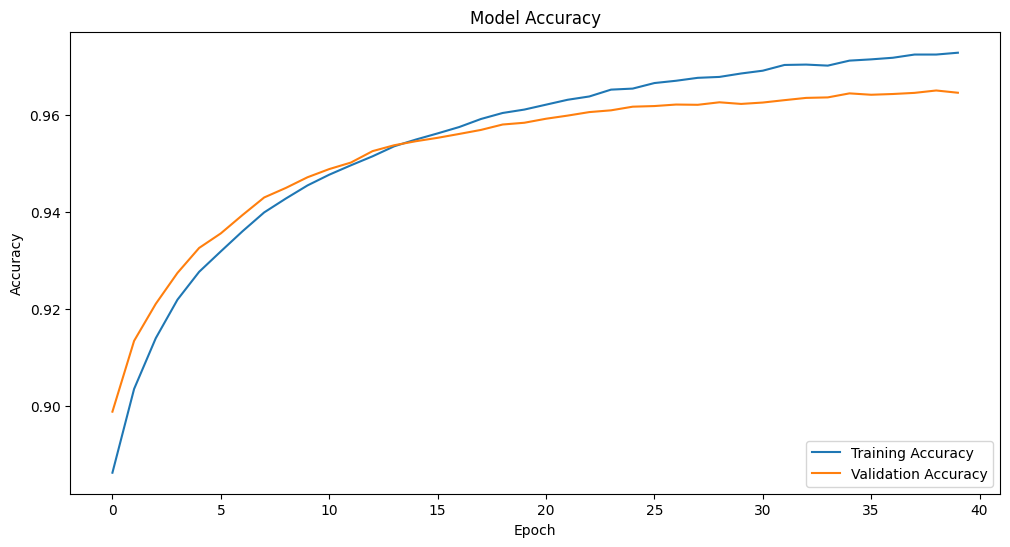

In [ ]:
# Fine-tune the model using the fine-tuning dataset
fine_tune_history = model.fit(
    X_fine_tune_train, y_fine_tune_train,
    epochs=40,  # Fewer epochs for fine-tuning
    batch_size=64,
    validation_data=(X_fine_tune_val, y_fine_tune_val),
    callbacks=[early_stopping]
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(X_fine_tune_val, y_fine_tune_val)
print(f"Fine-Tune Loss: {fine_tune_loss}, Fine-Tune Accuracy: {fine_tune_accuracy}")

# Save the fine-tuned model
model.save("/content/drive/MyDrive/models/SMILES_Gen/TD_128_L8_H4_fine_tuned.keras")


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9658 - loss: 0.1171 
Fine-Tune Loss: 0.11928564310073853, Fine-Tune Accuracy: 0.9651153087615967


In [ ]:
print(len(fine_tuning_smiles_list))

1053


In [ ]:
# Generate a new SMILES string
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=1.0)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles_fine_tuned = evaluate_generated_smiles(generated_smiles_list, fine_tuning_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles_fine_tuned)

  1%|          | 1/100 [00:03<05:49,  3.53s/it]

Cc1oc(-c2ccccc2F)nc1COc1cccc(c1)C(=O)NC[C@H](N)C(O)=O


  2%|▏         | 2/100 [00:07<06:27,  3.95s/it]

CC(C)(C)c1ccc(cc1)C(=O)c1sc(NC(=O)C2(CC2)c2ccc3OCOc3c2)nc1-c1ccccc1


  3%|▎         | 3/100 [00:12<07:05,  4.39s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccc(F)cc1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


  4%|▍         | 4/100 [00:18<07:56,  4.96s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)N1CC[C@H](OCC2C3CC3C4CC(C4)C2)C1=O


  5%|▌         | 5/100 [00:23<08:00,  5.06s/it]

COc1ccc(NC(=O)c2cnn(c2)-c2ccc3c(n2)N2C[C@H](CC2(C)C)CCCn2ccc(n2)S(=O)(=O)NC3=O)cc1


  6%|▌         | 6/100 [00:26<06:41,  4.28s/it]

Cc1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1c(F)cccc1F


  7%|▋         | 7/100 [00:29<06:03,  3.91s/it]

Clc1cccc(c1)-c1csc(NC(=O)C2(CC2)c2ccc3OCOc3c2)n1


  8%|▊         | 8/100 [00:34<06:40,  4.36s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cnn(CCCC2)c1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


  9%|▉         | 9/100 [00:37<05:38,  3.72s/it]

CN(C(=O)CNC(=O)c1cccnc1N)C(Cl)(Cl)Cl


 10%|█         | 10/100 [00:42<06:05,  4.06s/it]

OC(=O)c1cccc(c1)[C@H]1C[C@@H](C[C@H](O1)c1ccccc1)N1C[C@@H](CCc2ccccc2)NC1=O


 11%|█         | 11/100 [00:44<05:16,  3.55s/it]

COc1ccccc1CCc1cc(N)n(n1)-c1ccc(OC)cc1


 12%|█▏        | 12/100 [00:47<05:09,  3.52s/it]

Cn1c2c3C(NCCn3c(-c3ccccc3)c2c(=O)n(C)c1=O)c1cccc(Cl)c1


 13%|█▎        | 13/100 [00:52<05:29,  3.78s/it]

O=C(Nc1nc(c(s1)C(=O)c1ccc(cc1)-c1cccs1)-c1cccs1)C1(CC1)c1ccc2OCOc2c1


 14%|█▍        | 14/100 [00:55<05:15,  3.67s/it]

COc1ccc(Cl)cc1Nc1nc-2c(CCCc3nc(NC(=O)C(C)(C)C)sc-23)s1


 15%|█▌        | 15/100 [00:59<05:19,  3.76s/it]

CC(C)(C)c1cc(F)ccc1NC(=O)c1cc(-c2cnc(nc2)C(F)(F)F)c2c(N)ncnn12


 16%|█▌        | 16/100 [01:04<05:41,  4.07s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccnc(n1)SCCC2)-n1c(CC2(CC2)C(F)(F)F)cn1


 17%|█▋        | 17/100 [01:09<06:07,  4.42s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCCCC2(C(C)(C)C)n1)n1


 18%|█▊        | 18/100 [01:13<05:35,  4.09s/it]

[O-][N+](=O)c1cccc(c1)-c1nc2ccccc2[n+](=O)c2ccccc12


 19%|█▉        | 19/100 [01:16<05:10,  3.83s/it]

CCCCN(C(=O)[C@](O)(C(F)(F)F)C(F)(F)F)c1ccc2c(c1)OCO2


 20%|██        | 20/100 [01:19<04:49,  3.62s/it]

Ic1cccc(c1)-c1nc(nc2CCN(Cc3ccccc3)Cc3c12)-c1cccnc1


 21%|██        | 21/100 [01:21<04:19,  3.28s/it]

Cc1ccccc1NC(=O)C1CC(c2ccc(O)c(O)c2)=NO1


 22%|██▏       | 22/100 [01:25<04:20,  3.34s/it]

COc1ccc2nc3CCN(Cc3[nH]c3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F


 23%|██▎       | 23/100 [01:28<04:00,  3.12s/it]

COc1ccc(Cl)cc1\C=C1/SC(=S)N(C1=O)c1ccccc1


 24%|██▍       | 24/100 [01:31<04:01,  3.17s/it]

OC(=O)c1ccc(\C=C2/SC(=S)N(C2=S)c2cccc(c2)C(F)(F)F)cc1


 25%|██▌       | 25/100 [01:35<04:12,  3.36s/it]

COc1cccc(c1)C(=O)c1sc(NC(=O)C2(CC2)c2ccc3OCOc3c2)nc1-c1ccccc1


 26%|██▌       | 26/100 [01:38<04:09,  3.37s/it]

Oc1ccc(Br)cc1C(=O)c1csc(NC(=O)C2(CC2)c2ccc3OCOc3c2)n1


 27%|██▋       | 27/100 [01:42<04:13,  3.48s/it]

Cc1ccc(o1)C1Nc2ccccc2-n2c1c1n(C)c(=O)n(C)c(=O)c1c2-c1ccccc1


 28%|██▊       | 28/100 [01:47<04:43,  3.93s/it]

O[C@@H](CNCc1ccc(F)cc1)COc1ccc2c(n1)N1C[C@H](CC1(C)C)CCCNc1cccc(n1)S(=O)(=O)NC2=O


 29%|██▉       | 29/100 [01:51<04:41,  3.97s/it]

CCCCCc1ccc(NC(=O)[C@H]2Cc3ccccc3CN2C(=O)c2ccnc(Oc3ccccc3)c2)cc1


 30%|███       | 30/100 [01:53<04:06,  3.52s/it]

COc1ccc(OC)c(NC(=O)c2sc3nc(C)oc-3c2C)c1


 31%|███       | 31/100 [01:56<03:49,  3.33s/it]

CC1CCCCCC1NC(=O)C1(C)CCN1C(=O)c1ccccc1C(F)(F)F


 32%|███▏      | 32/100 [01:59<03:27,  3.05s/it]

CC(C)C[C@@H](O)Cn1c(N)nc2ccc(F)cc2c1=O


 33%|███▎      | 33/100 [02:02<03:26,  3.08s/it]

CN(Cc1ccccc1)S(=O)(=O)c1cc(-n2cc3nc(C)ccc3oc2=O)cs1


 34%|███▍      | 34/100 [02:07<04:10,  3.80s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCC2)n1)N1CC[C@H](OCC2(CC2)C(F)(F)F)C1=O


 35%|███▌      | 35/100 [02:12<04:29,  4.14s/it]

CC1(C)CCC2CCCNc3cccc(n3)S(=O)(=O)NC(=O)c3ccc(nc3N12)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 36%|███▌      | 36/100 [02:15<04:08,  3.88s/it]

C1CCCCCC1CNc1ncn2c3CN(CCc4c([nH]c4-c4ccccc4)c3c12)CC3


 37%|███▋      | 37/100 [02:20<04:10,  3.98s/it]

[O-][N+](=O)c1cccc(c1)-c1nc2cccc3c2n(c1=O)-](CC1CC1)C[S+]([O-])=O


 38%|███▊      | 38/100 [02:25<04:30,  4.37s/it]

CCc1nc(C(=O)NO[C@H]3CC[C@@H](C3)N(Cc3ccc(N)cc3)C(=O)c2cc([N+]([O-])=O)ccc2O1)C(C)(C)C


 39%|███▉      | 39/100 [02:29<04:22,  4.30s/it]

CN(C(=O)CN1C(=O)c2ccccc2C1=O)c1ccc2Brn([n+]([O-])=O)c(=O)c2ccccc12


 40%|████      | 40/100 [02:32<03:50,  3.83s/it]

CCn1nc(\C=C\[C@H](O)CC(O)=O)c(cc1N)C(F)(F)F


 41%|████      | 41/100 [02:35<03:43,  3.79s/it]

CC(C)(C)c1ccc(NC(=O)[C@H]2Cc3ccccc3CN2C(=O)c2cc(Cl)ccn2)cc1


 42%|████▏     | 42/100 [02:38<03:10,  3.28s/it]

CCCCc1cc(O)c2c(c1)Br)C(O)c1cccc(N


 43%|████▎     | 43/100 [02:43<03:49,  4.03s/it]

CC1(C)C[C@@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)N1CC[C@H](OCCC23CC4(CC(CC4)C2)C3)C1=O


 44%|████▍     | 44/100 [02:46<03:30,  3.75s/it]

O=C(Nc1ccc2nc(nc2c1)-c1ccco1)c1cc([nH]n1)C(F)(F)F


 45%|████▌     | 45/100 [02:50<03:20,  3.65s/it]

COc1ccc(Cl)cc1Nc1nc-2c(CCCCc3nc(NC(=O)C(C)(C)C)sc-23)s1


 46%|████▌     | 46/100 [02:54<03:24,  3.79s/it]

Clc1ccc2[nH]c3CC[C@@H]4CN(Cc4cc(OC(F)(F)F)[nH]n4)C(=O)[C@H](C)N2c1


 47%|████▋     | 47/100 [03:00<03:49,  4.33s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)N1CC[C@H](OCCC2C3(CC3)C22CC2)C1=O


 48%|████▊     | 48/100 [03:02<03:15,  3.76s/it]

Cc1ccc(o1)C1OCc2c1C(O1)c1cccc(O)c1OC2=O


 49%|████▉     | 49/100 [03:06<03:15,  3.84s/it]

CCCCCCc1ccc(NC(=O)[C@@H]2Cc3ccccc3CN2C(=O)c2cccc(Oc3ccccc3)c2)cc1


 50%|█████     | 50/100 [03:11<03:27,  4.15s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 51%|█████     | 51/100 [03:14<03:09,  3.87s/it]

Cc1ccc(o1)C1Oc2ccc(cc2-n2c1c1nc(C)c(=O)o1)C(F)(F)F


 52%|█████▏    | 52/100 [03:17<02:54,  3.63s/it]

[O-][N+](=O)c1cccc(c1)-c1nc2ccccc2n(Cc2ccccc2)c1=O


 53%|█████▎    | 53/100 [03:20<02:40,  3.42s/it]

CC(C)(C)CCN1CCN(C1=O)c1nc2ccccc2n(Cc2ccco2)c1=O


 54%|█████▍    | 54/100 [03:23<02:26,  3.18s/it]

COc1ccc(Cl)cc1NC(=O)C1(CC1)c1ccc2OCOc2c2c1


 55%|█████▌    | 55/100 [03:26<02:20,  3.13s/it]

CC(C)(C1CC1)c1ccc(NC(=O)C2(CC2)c2ccc3OCOc3c2)cc1


 56%|█████▌    | 56/100 [03:29<02:19,  3.18s/it]

CCCCS(=O)(=O)NCCc1csc(n1)S(=O)(=O)c1cccc2nc(C)ccc12


 57%|█████▋    | 57/100 [03:34<02:38,  3.68s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 58%|█████▊    | 58/100 [03:37<02:26,  3.48s/it]

COc1ccc(S(=O)(=O)N2CCC(CC2)c2nc(cs2)-c2ccco2)cc1


 59%|█████▉    | 59/100 [03:39<02:09,  3.17s/it]

N#Cc1ccc(NC(=O)c2c[nH]c3ccccc3c2=O)cc1


 60%|██████    | 60/100 [03:41<01:51,  2.80s/it]

CN1CCN(CCNC(=O)c2nc(C)sc2C)CC1


 61%|██████    | 61/100 [03:44<01:52,  2.89s/it]

CC(O)c1ccccc1/C=C1/SC(=S)N(C1=O)c1ccc(cc1)C(F)(F)F


 62%|██████▏   | 62/100 [03:48<01:55,  3.03s/it]

Cn1nc2c3C(NCCn3c(-c3ccccc3)c2c(=O)n(C)c1=O)c1cccc(Cl)c1


 63%|██████▎   | 63/100 [03:53<02:14,  3.63s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(CCCC2)c1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 64%|██████▍   | 64/100 [03:56<02:10,  3.62s/it]

O=C(Nc1nnc(o1)-c1cc(sc1Cl)-c1nc(O)c2ccccc2n1)[N+]([O-])=O


 65%|██████▌   | 65/100 [03:58<01:48,  3.10s/it]

COc1ccccc1COC(=O)c1ccc2OCOc2c1


 66%|██████▌   | 66/100 [04:03<02:03,  3.62s/it]

O=C(CNC(=O)c1ccc2c(n1)CCN(Cc1ccccc1)C(=O)C2=O)NCc1ccc2c(n1)N(CC2CCCCO2)C(F)(F)F


 67%|██████▋   | 67/100 [04:05<01:42,  3.12s/it]

Cc1cccnc1NC(=O)Cn1cnc2sccc2c1=O


 68%|██████▊   | 68/100 [04:09<01:46,  3.32s/it]

CC1CN(C(=O)C1c1ccc2[nH]c3CCCC(=O)Nc3c2)c1cc(Cl)cc2nc(C)cnc12


 69%|██████▉   | 69/100 [04:13<01:48,  3.48s/it]

CN1CCN(CCCNc2nc(nc3CCN(Cc4ccccc4)Cc23)-c2cnn([nH]2)C(F)(F)F)CC1


 70%|███████   | 70/100 [04:18<01:57,  3.93s/it]

CC1(C)CC2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 71%|███████   | 71/100 [04:22<01:56,  4.00s/it]

CC[C@@](O)(CNC(=O)c1nc(-c2ccc(OC)c(OCC)c2)c(cc1N)C(F)(F)F)C(F)(F)F


 72%|███████▏  | 72/100 [04:23<01:28,  3.15s/it]

CN(C)c1ccc(Cl)cc1N


 73%|███████▎  | 73/100 [04:28<01:40,  3.74s/it]

CC1(C)CC[C@]2(CCCN1[C@@H]1C[C@H](n3cc(c(=O)n(C)c3)S(=O)(=O)c2cccc3O1)C1CCCC1)C(O)=O


 74%|███████▍  | 74/100 [04:31<01:32,  3.54s/it]

Nc1sc2c(c1C(=O)c1cc(Br)cs1)CCc1cc(OC(F)(F)F)ccc1-2


 75%|███████▌  | 75/100 [04:34<01:20,  3.21s/it]

CCCc1ccc(NC(=O)c2c[nH]c3ccccc3c2=O)cc1N


 76%|███████▌  | 76/100 [04:37<01:20,  3.37s/it]

[O-]S(=O)(=O)c1ccc(\C=C/C=C2/SC(=S)N(C2=O)c2cccc(c2)C#N)cc1


 77%|███████▋  | 77/100 [04:40<01:11,  3.10s/it]

Cc1nc2ccc([nH]1)C(=O)C(CCc1ccccc1)=NCCN2


 78%|███████▊  | 78/100 [04:45<01:18,  3.59s/it]

CC(C)(C)CCOc1cn(nn1)-c1ccc2c(n1)N1C[C@H](CC1(C)C)CCCNc1cccc(n1)S(=O)(=O)NC2=O


 79%|███████▉  | 79/100 [04:48<01:14,  3.55s/it]

CCC(c1cn(nn1)-c1ccccc1F)c1c(C#N)c(-c2cncnc2)c2c(N)ncnn12


 80%|████████  | 80/100 [04:54<01:27,  4.38s/it]

CC(C)(C)c1c2cc(NC(=O)[C@@H]3CCCC[C@@H]3C(=O)N(C(C)=O)C[C@@H]([C@@H](N)Cc3cccc3)C(F)(F)F)cc2c(O)cccc12O


 81%|████████  | 81/100 [04:58<01:21,  4.29s/it]

CN1CCn2c(nc3c(nc(NC(=O)C4CCCCC4)nc(N)c32)-c2cccc1C#N)N1CCC(C)(C)CC1


 82%|████████▏ | 82/100 [05:01<01:06,  3.69s/it]

CC(C)(C)c1cc(c(N)n1)-c1cccc2ccccc12


 83%|████████▎ | 83/100 [05:03<00:56,  3.35s/it]

Cc1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1c[nH]cn1


 84%|████████▍ | 84/100 [05:06<00:52,  3.31s/it]

NC(=O)c1cc(sc1NC(=O)C1=COCO1)S(=O)(=O)c1cc(Cl)ccc1Cl


 85%|████████▌ | 85/100 [05:12<00:57,  3.86s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCCCC2)n1)-n1ccc(OCCC2(CC2)C(F)(F)F)n1


 86%|████████▌ | 86/100 [05:15<00:50,  3.63s/it]

COc1ccc(Cl)cc1Nc1nc(cs1)-c1sc(NC(=O)C(C)(C)C)nc1C


 87%|████████▋ | 87/100 [05:18<00:45,  3.47s/it]

Cc1cc2[nH]c3CCN(Cc3c2cc1)C(=O)c1cc([nH]n1)C(F)(F)F


 88%|████████▊ | 88/100 [05:20<00:37,  3.15s/it]

CN(C)CCNC(=O)c1nc(c(cc1N)C#N)-c1ccccc1F


 89%|████████▉ | 89/100 [05:28<00:51,  4.68s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NS(=O)(=O)c2cn(CCO)cc2)c1)-n1ccc(OCCCC2(CC2C2(CC2)(C2)C2)C2)C2C2C2C2CCCCCC22)C21)(C2)C2


 90%|█████████ | 90/100 [05:32<00:44,  4.48s/it]

CCCCCc1ccc(NC(=O)[C@@H]2Cc3ccccc3CN2C(=O)c2cccc(Oc3ccccc3)c2)cc1


 91%|█████████ | 91/100 [05:34<00:33,  3.71s/it]

CN1CCc2[nH]c3c(F)ccc(C)c3c2C1=O


 92%|█████████▏| 92/100 [05:40<00:33,  4.22s/it]

CC1(C)CCC2CCCNc3cccc(n3)S(=O)(=O)NC(=O)c3ccc(nc3N1(C)C)C(=O)c1ccc(OCCC2(CC2)C(F)(F)F)nc1


 93%|█████████▎| 93/100 [05:41<00:22,  3.27s/it]

COC(=O)c1ccccc1N


 94%|█████████▍| 94/100 [05:46<00:22,  3.71s/it]

Fc1ccc2[nH]c3CCN(Cc3c2c1)C(=O)c1cc([nH]n1)C(F)(F)F


 95%|█████████▌| 95/100 [05:50<00:19,  3.87s/it]

CCCCCc1ccc(NC(=O)[C@H]2Cc3ccccc3CN2C(=O)c2cc(Cl)cc(OCCO3)c2)cc1


 96%|█████████▌| 96/100 [05:53<00:14,  3.73s/it]

Cc1noc(C)c1CC(O)CN(C(=O)c1cccc(c1)N2)c1cccc(Cl)c1


 97%|█████████▋| 97/100 [05:59<00:13,  4.42s/it]

CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1ccn(CCC2)n1)N1CC[C@H](OCC2C3(CC3)C22CC2)C1=O


 98%|█████████▊| 98/100 [06:04<00:08,  4.43s/it]

CN(C)c1ccc(C(=O)N2CCN(CC2)c2nc(nc3CCN(Cc4ccccc4)Cc23)-c2ccccn2)cc1


 99%|█████████▉| 99/100 [06:08<00:04,  4.35s/it]

CCCCCc1ccc(NC(=O)[C@@H]2Cc3ccccc3CN2C(=O)c2cc(OC(C)C)ccn2)cc1


100%|██████████| 100/100 [06:11<00:00,  3.71s/it]

COc1ccc(NC(=O)c2c[nH]c3ccccc3c2=O)cc1OC

Percent valid: 70.000%
Percent unique: 74.286%
['[O-]S(=O)(=O)c1ccc(\\C=C/C=C2/SC(=S)N(C2=O)c2cccc(c2)C#N)cc1', 'CC(C)(C1CC1)c1ccc(NC(=O)C2(CC2)c2ccc3OCOc3c2)cc1', 'COc1ccc(Cl)cc1\\C=C1/SC(=S)N(C1=O)c1ccccc1', 'NC(=O)c1cc(sc1NC(=O)C1=COCO1)S(=O)(=O)c1cc(Cl)ccc1Cl', 'COc1ccccc1CCc1cc(N)n(n1)-c1ccc(OC)cc1', 'CN(C(=O)CNC(=O)c1cccnc1N)C(Cl)(Cl)Cl', 'COc1ccc(Cl)cc1Nc1nc(cs1)-c1sc(NC(=O)C(C)(C)C)nc1C', 'CN(C)c1ccc(C(=O)N2CCN(CC2)c2nc(nc3CCN(Cc4ccccc4)Cc23)-c2ccccn2)cc1', 'Clc1cccc(c1)-c1csc(NC(=O)C2(CC2)c2ccc3OCOc3c2)n1', 'CN1CCc2[nH]c3c(F)ccc(C)c3c2C1=O', 'CC1(C)C[C@H]2CN1c1nc(ccc1C(=O)NS(=O)(=O)c1cccc(NCCC2)n1)N1CC[C@H](OCCC2C3(CC3)C22CC2)C1=O', 'CC(O)c1ccccc1/C=C1/SC(=S)N(C1=O)c1ccc(cc1)C(F)(F)F', 'CC(C)(C)CCOc1cn(nn1)-c1ccc2c(n1)N1C[C@H](CC1(C)C)CCCNc1cccc(n1)S(=O)(=O)NC2=O', '[O-][N+](=O)c1cccc(c1)-c1nc2ccccc2n(Cc2ccccc2)c1=O', 'CC(C)(C)CCN1CCN(C1=O)c1nc2ccccc2n(Cc2ccco2)c1=O', 'OC(=O)c1cccc(c1)[C@H]1C[C@@H](C[C@H](O1)c1ccccc1)N1C[C@@H](CCc2ccccc

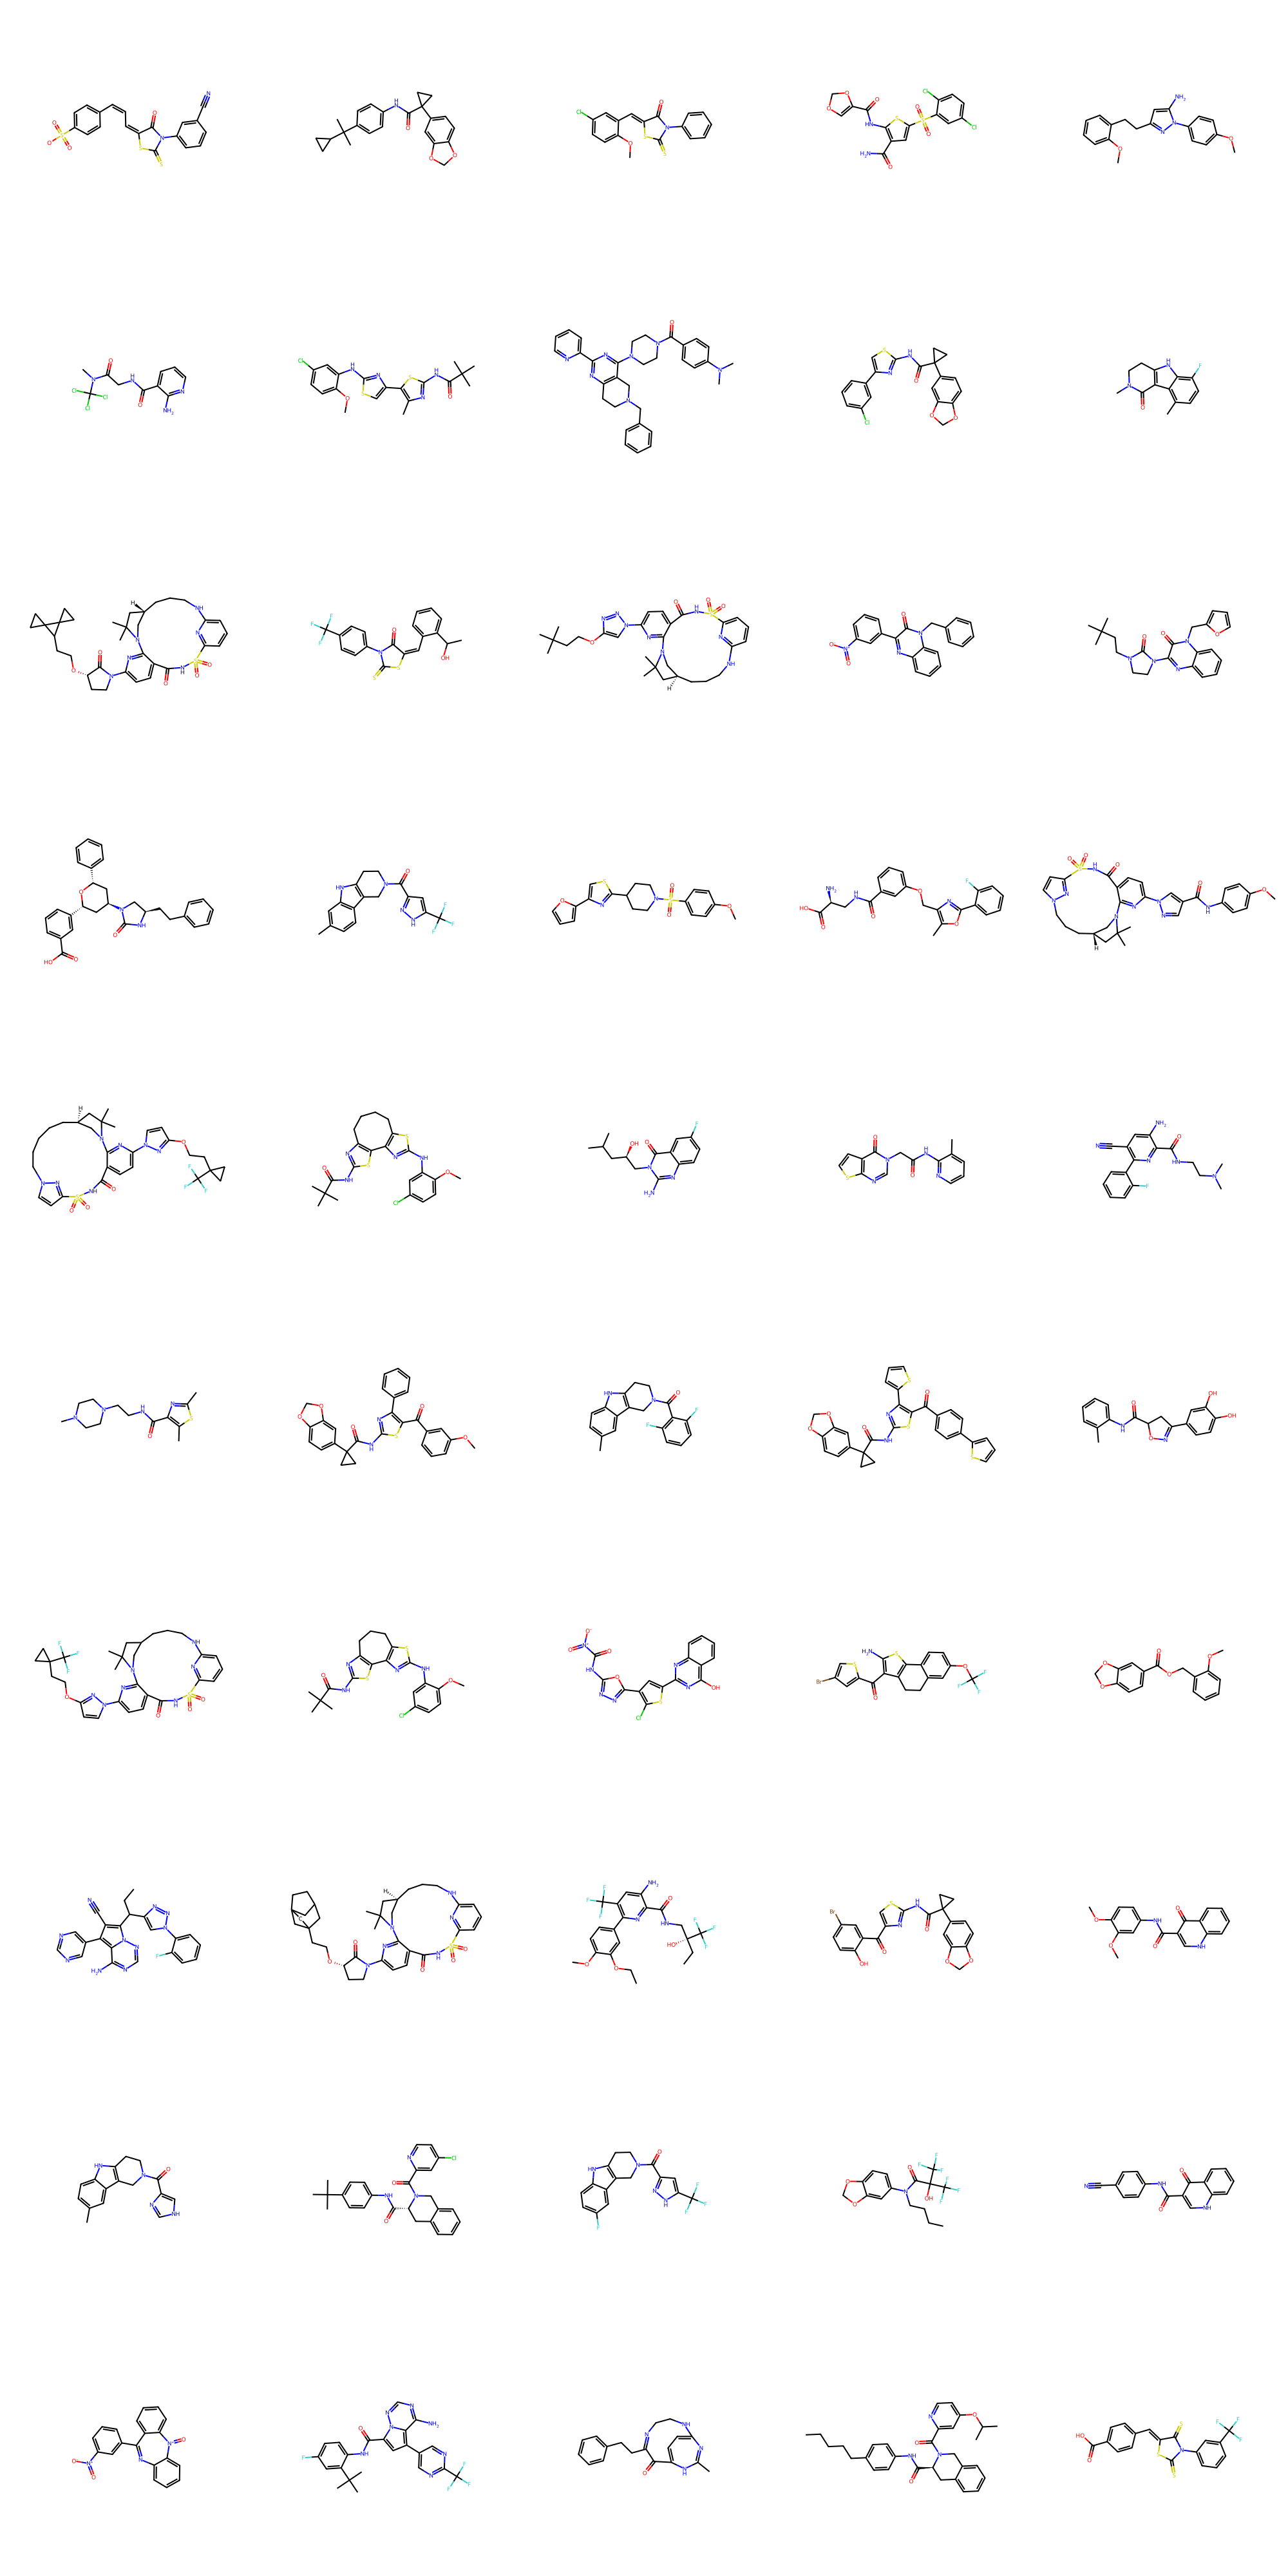

In [ ]:
# Display the first 10 unique valid SMILES strings as a grid image
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in unique_valid_smiles_fine_tuned[:50]]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)

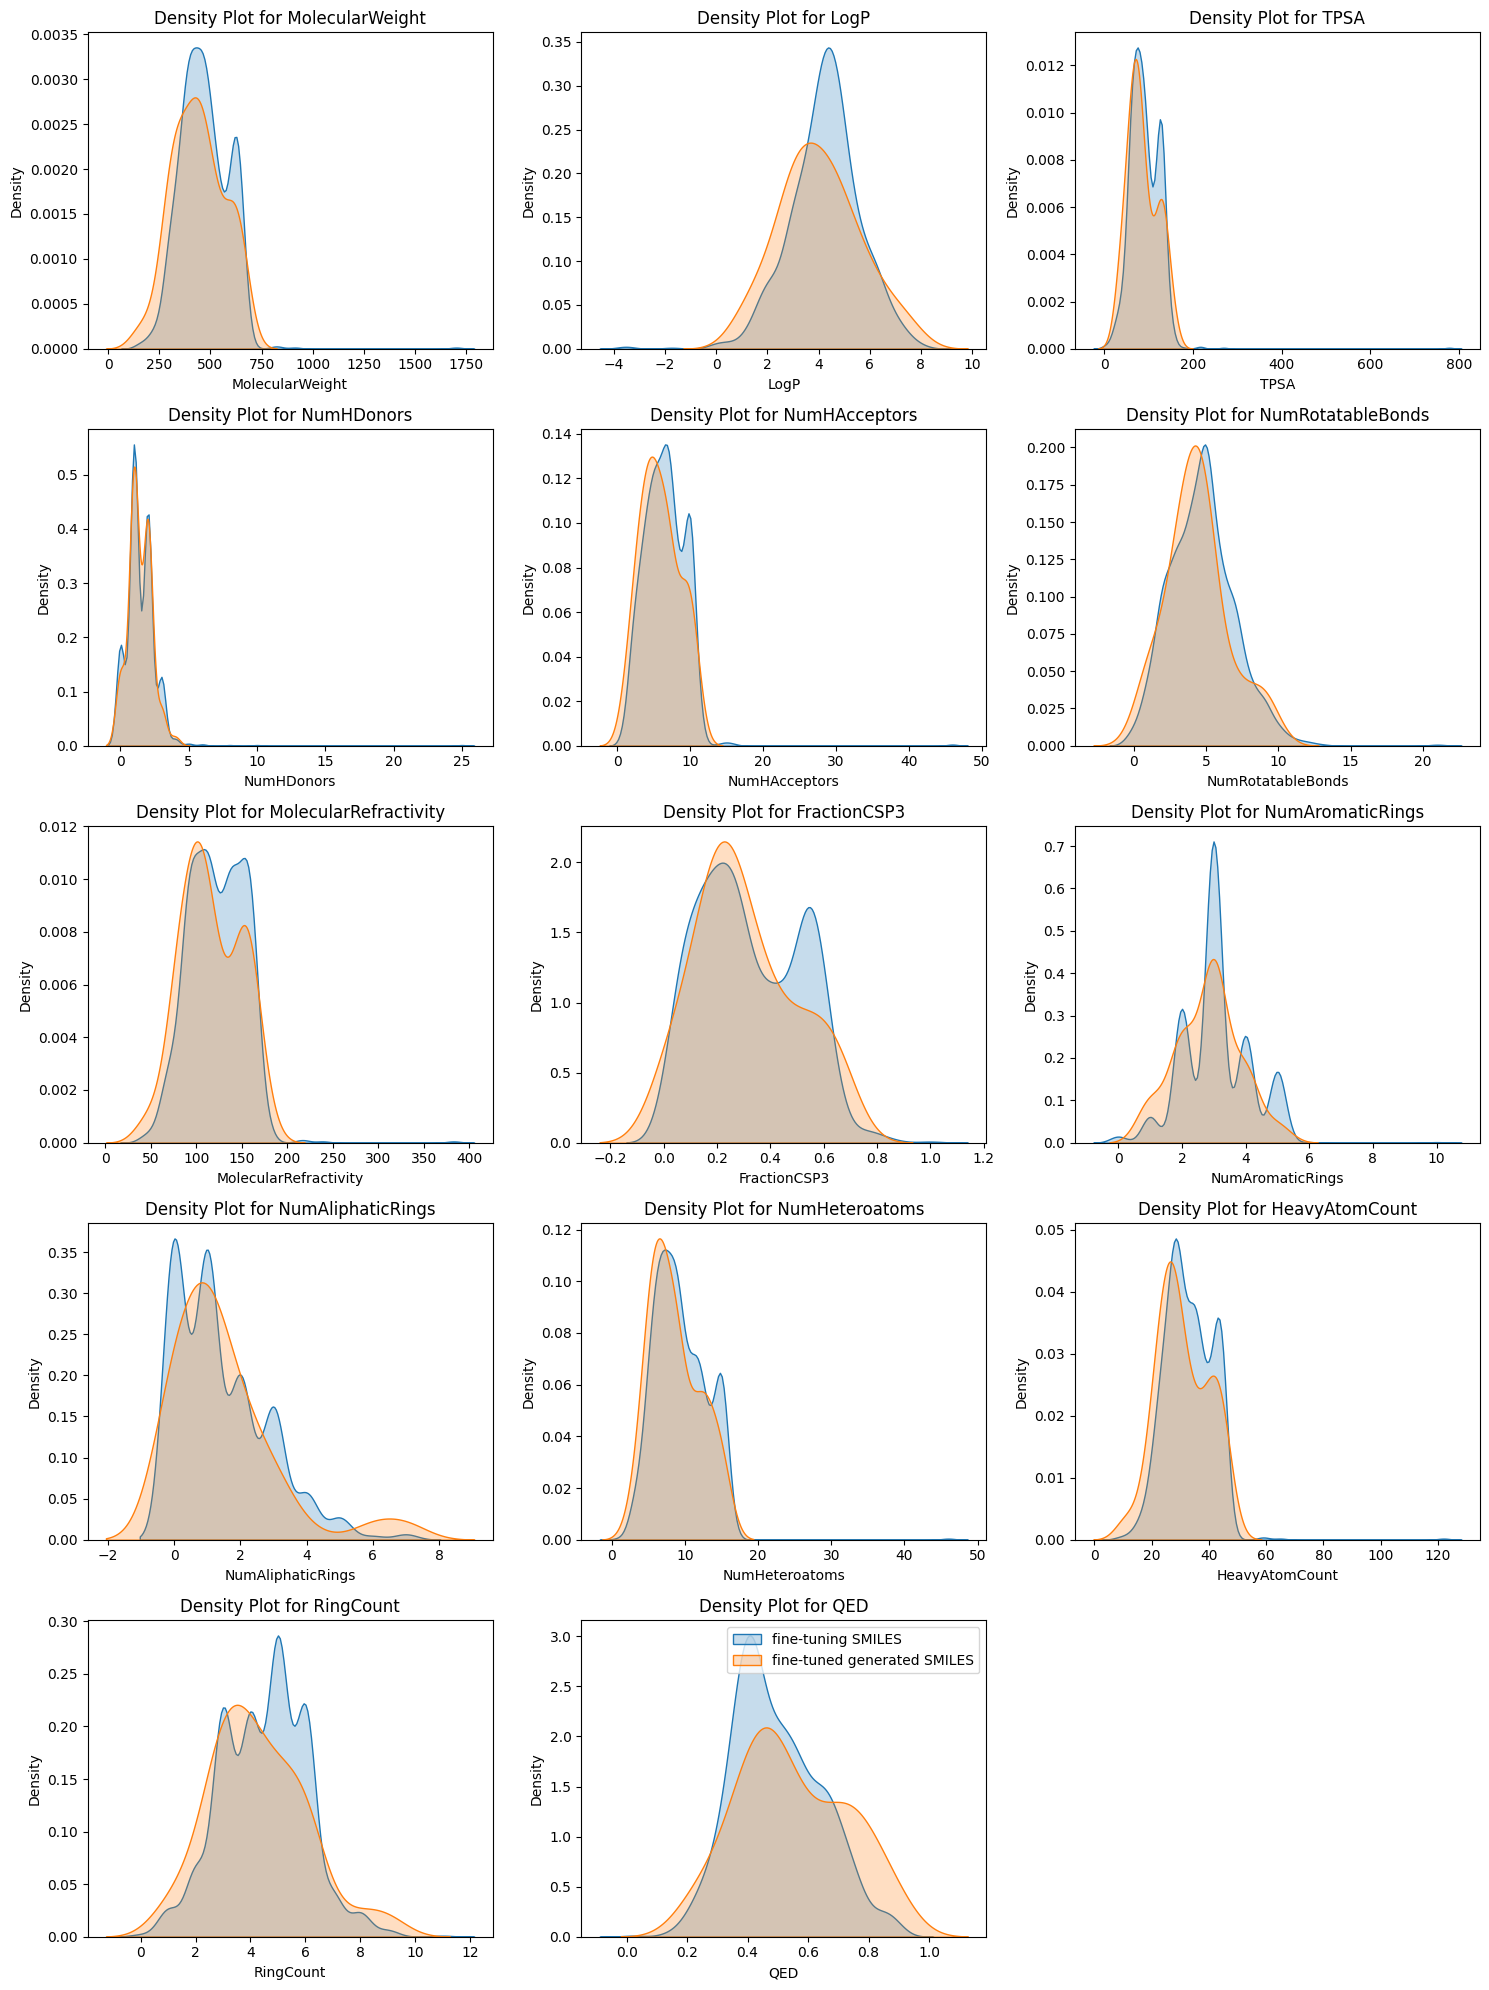

In [ ]:
# Create dataframes from generated SMILES data to store molecular descriptors
fine_tuning_df = pd.DataFrame(fine_tuning_smiles_list, columns=['SMILES'])
generated_df_fine_tuned = pd.DataFrame(unique_valid_smiles_fine_tuned, columns=['SMILES'])

# Apply the descriptor function to each row in the dataframe
descriptor_columns_fine_tuned = fine_tuning_df['SMILES'].apply(compute_descriptors)
descriptor_columns_gen_fine_tuned = generated_df_fine_tuned['SMILES'].apply(compute_descriptors)

# Convert the series of dictionaries into a DataFrame
descriptors_fine_tuned_df = pd.DataFrame(descriptor_columns_fine_tuned.tolist())
descriptors_gen_df_fine_tuned = pd.DataFrame(descriptor_columns_gen_fine_tuned.tolist())

# Merge the descriptors back into the original dataframe
fine_tuning_data = pd.concat([fine_tuning_df, descriptors_fine_tuned_df], axis=1)
gen_data_fine_tuned = pd.concat([generated_df_fine_tuned, descriptors_gen_df_fine_tuned], axis=1)

# Display the updated dataframe
# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

descriptor_cols = descriptors_df.columns.to_list()

# Loop through the columns and create a density plot for each
for i, column in enumerate(descriptor_cols, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(fine_tuning_data[column], fill=True, label='fine-tuning SMILES')
    sns.kdeplot(gen_data_fine_tuned[column], fill=True, label='fine-tuned generated SMILES')
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
plt.show()


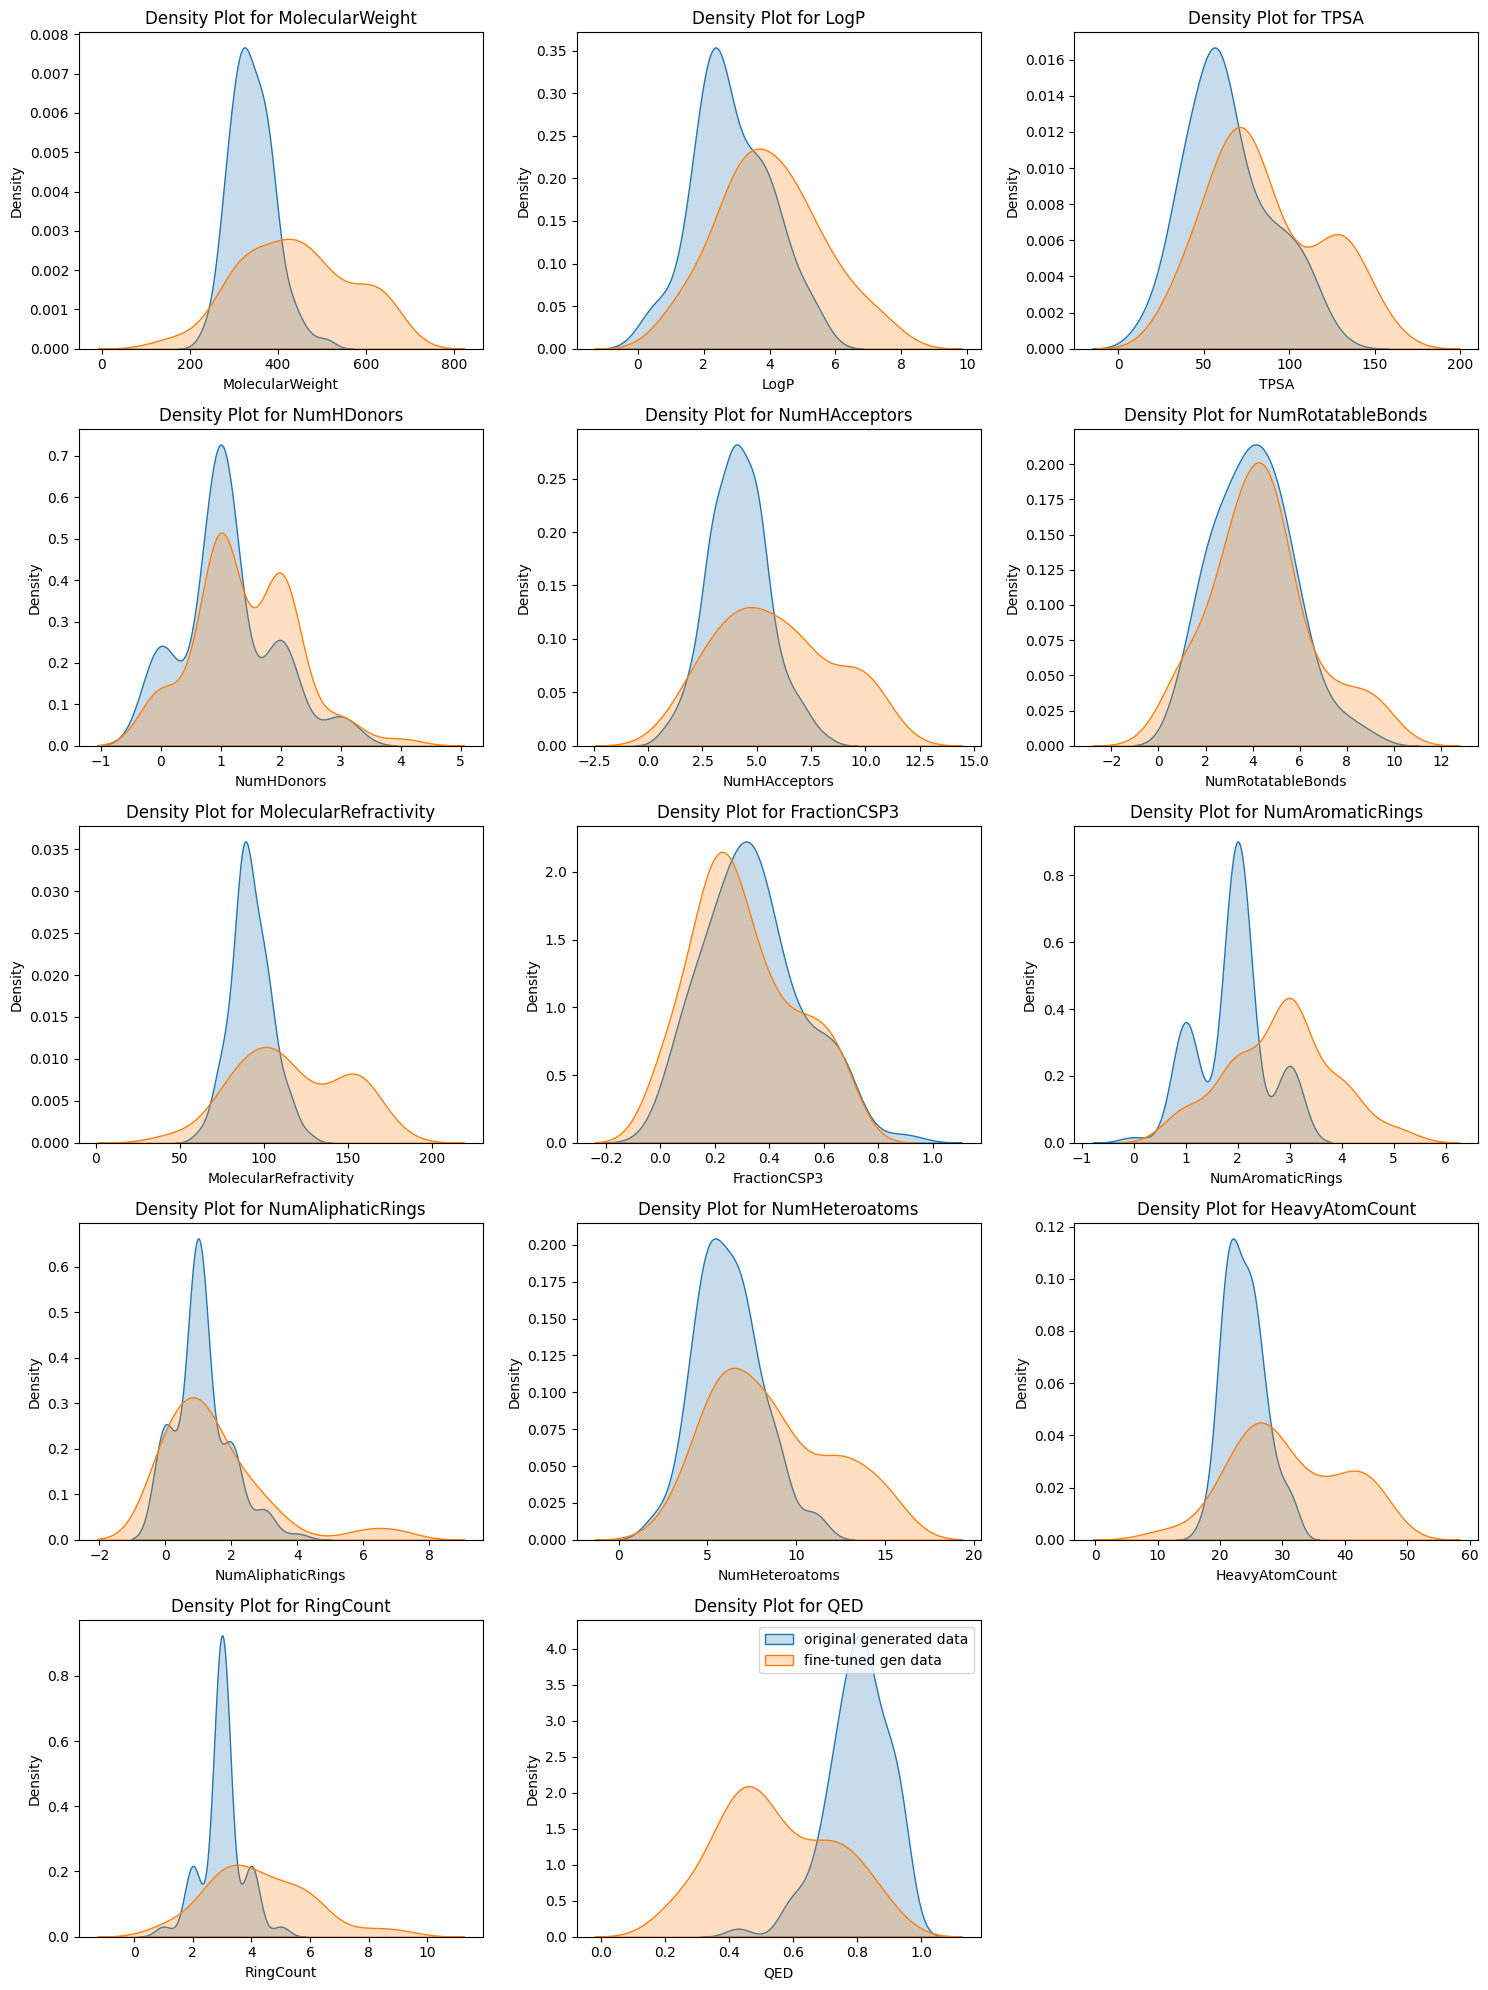

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

descriptor_cols = descriptors_df.columns.to_list()

# Loop through the columns and create a density plot for each
for i, column in enumerate(descriptor_cols, 1):
    plt.subplot(5, 3, i)
    sns.kdeplot(gen_data[column], fill=True, label='original generated data')
    sns.kdeplot(gen_data_fine_tuned[column], fill=True, label='fine-tuned gen data')
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
plt.show()


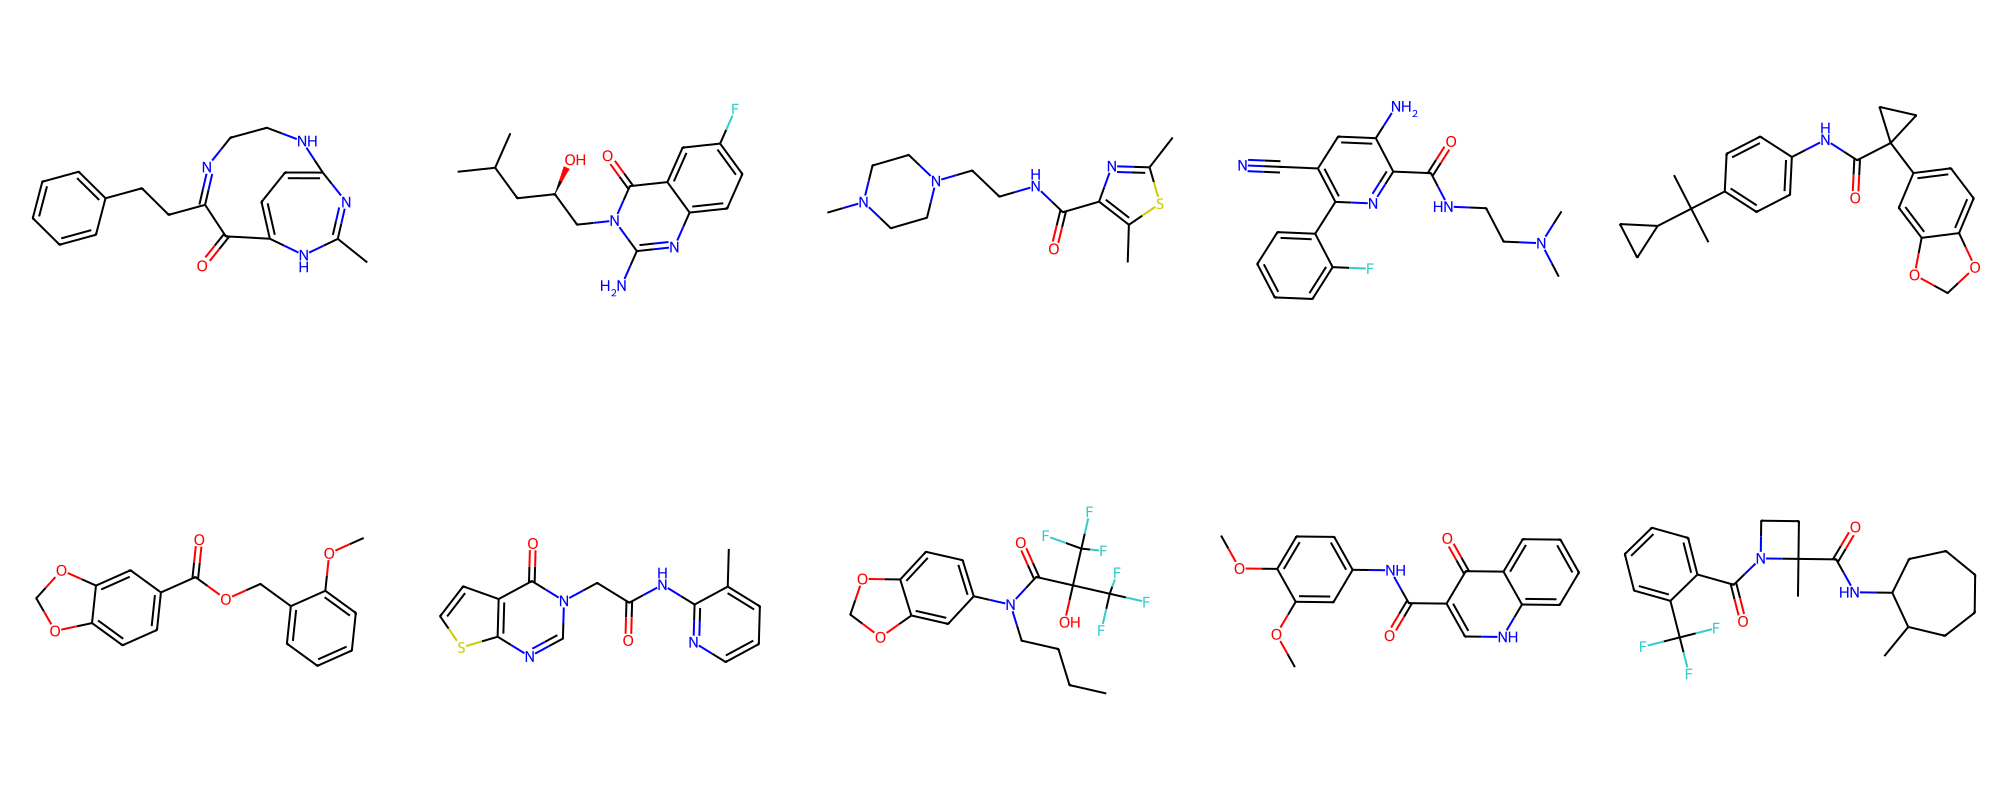

In [ ]:
# Top Drug-like molecules
top_10 = gen_data_fine_tuned.sort_values(by='QED', ascending=False)[:10]

molecule_list = [Chem.MolFromSmiles(smiles) for smiles in top_10['SMILES']]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)